This notebook includes evaluation scripts run on a **simulated dataset that consists of only 5 samples**.

In [17]:
import warnings
warnings.filterwarnings("ignore")
import os 
import json
import pandas as pd
import numpy as np
from lifelines.utils import concordance_index
from scipy.stats import bootstrap
import yaml
from sklearn.utils import resample

# Function to load configuration
def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# Function to load ground truth
def load_ground_truth(dataset, ground_truth_path):
    file_path = f"{ground_truth_path}{dataset}.csv"
    return pd.read_csv(file_path, dtype={"case_id": str})

# Function to load predictions
def load_predictions(input_dir, teams, datasets):
    predictions = {}
    for team in teams:
        predictions[team] = {}
        for dataset_dict in datasets:
            dataset = list(dataset_dict.keys())[0]
            dataset_path = os.path.join(input_dir, team, dataset)
            if not os.path.exists(dataset_path):
                continue
            team_dataset_preds = {}
            
            if len(os.listdir(dataset_path)) == list(dataset_dict.values())[0]:
                for file_name in os.listdir(dataset_path):
                    if file_name.endswith('.json'):
                        case_id = file_name.replace('.json', '')
                        with open(os.path.join(dataset_path, file_name), 'r') as f:
                            team_dataset_preds[case_id] = json.load(f)
            else:
                print(f"Dataset {dataset} predictions for team {team} are incomplete, expected {list(dataset_dict.values())[0]} files, found {len(os.listdir(dataset_path))} files")
            
            if team_dataset_preds:
                predictions[team][dataset] = team_dataset_preds
    return predictions

# Function to compute C-index and standard deviation
def compute_c_index(predictions, datasets, ground_truth_path, official_team_names, official_dataset_names):
    results = {}
    results_csv = {}
    teams = set(predictions.keys())
    dataset_names = [list(dataset_dict.keys())[0] for dataset_dict in datasets]

    
    for team in teams:

        
        official_team_name = official_team_names[team]
        
        results[official_team_name] = {'Team': official_team_name}
        results_csv[official_team_name] = {'Team': official_team_name}
        c_index_list = []
        
        for dataset in dataset_names:
            official_dataset_name = official_dataset_names[dataset]
            if dataset not in predictions[team]:
                results[official_team_name][official_dataset_name] = 'N/A'
                results_csv[official_team_name][official_dataset_name] = 'N/A'
                
                continue
            
            preds = predictions[team][dataset]
            ground_truth = load_ground_truth(dataset, ground_truth_path)
            ground_truth_filtered = ground_truth[ground_truth['case_id'].isin(preds.keys())].copy()
            
            if ground_truth_filtered.empty:
                results[official_team_name][official_dataset_name] = 'N/A'
                results_csv[official_team_name][official_dataset_name] = 'N/A'
                continue
            
            ground_truth_filtered['prediction'] = ground_truth_filtered['case_id'].map(preds)
            c_index, ci_lower, ci_upper = bootstrap_c_index(
                events=ground_truth_filtered['event'].values, 
                times=ground_truth_filtered['follow_up_years'].values, 
                predictions=ground_truth_filtered['prediction'].values, 
                n_bootstraps=1
            )
            ci_formatted = f"${c_index:.3f}_{{({ci_lower:.3f}; {ci_upper:.3f})}}$"
            results[official_team_name][official_dataset_name] = ci_formatted
            results_csv[official_team_name][official_dataset_name+"_c_index"] = c_index
            results_csv[official_team_name][official_dataset_name+"_ci_upper"] = ci_upper
            results_csv[official_team_name][official_dataset_name+"_ci_lower"] = ci_lower
            c_index_list.append(c_index)
        
        # Compute average C-index and standard deviation
        if c_index_list:
            avg_c_index = np.mean(c_index_list)
            std_c_index = np.std(c_index_list, ddof=1)  # Sample standard deviation
            results[official_team_name]['Average C-index'] = f"${avg_c_index:.3f}_{{(\pm {std_c_index:.3f})}}$"
            results_csv[official_team_name]['Average C-index'] = avg_c_index
            results_csv[official_team_name]['stdev_c_index'] = std_c_index
        else:
            results[official_team_name]['Average C-index'] = 'N/A'
            results_csv[official_team_name]['Average C-index'] = 'N/A'
            results_csv[official_team_name]['stdev_c_index'] = 'N/A'
    
    df_results = pd.DataFrame.from_dict(results, orient='index').reset_index(drop=True)
    
    # Sort teams by average C-index (ignoring 'N/A' values)
    df_results = df_results[df_results['Average C-index'] != 'N/A']
    df_results = df_results.sort_values(by='Average C-index', ascending=False)
    
    df_results_csv = pd.DataFrame.from_dict(results_csv, orient='index').reset_index(drop=True)
    
    # Sort teams by average C-index (ignoring 'N/A' values)
    df_results_csv = df_results_csv[df_results_csv['Average C-index'] != 'N/A']
    df_results_csv = df_results_csv.sort_values(by='Average C-index', ascending=False)
    
    return df_results, df_results_csv

# Function to compute bootstrap confidence intervals
def bootstrap_c_index(events, times, predictions, n_bootstraps):
    original_c_index = concordance_index(times, predictions, events)
    c_index_bootstrap = np.zeros(n_bootstraps)
    
    for i in range(n_bootstraps):
        indices = resample(range(len(events)), replace=True, n_samples=len(events))
        c_index_bootstrap[i] = concordance_index(times[indices], predictions[indices], events[indices])
    
    ci_lower, ci_upper = np.percentile(c_index_bootstrap, [2.5, 97.5])
    return original_c_index, ci_lower, ci_upper

# Function to save results
def save_results(results, results_csv, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    csv_path = os.path.join(output_dir, 'c_index_results.csv')
    latex_path = os.path.join(output_dir, 'c_index_results.tex')
    
    
    
    with open(latex_path, 'w') as f:
        latex_output = results.to_latex(index=False, escape=False)
        #latex_output = latex_output.replace("_", "\\_")  # Ensuring LaTeX-friendly formatting
        f.write(latex_output)
        
    results_csv.to_csv(csv_path, index=False)


# Main function
def main(config_path):
    config = load_config(config_path)
    predictions = load_predictions(config['input_dir'], config['teams'], config['datasets'])
    results,results_csv = compute_c_index(predictions, config['datasets'], config['ground_truth_path'],config['team_names'],config['dataset_names'])
    print(results)
    save_results(results,results_csv, config['output_dir'])

if __name__ == '__main__':
    import sys
    config_path = r"C:\Users\khrys\Downloads\leopard-challenge-main-final\leopard-challenge-main\config\config-test.yaml"
    main(config_path)

                Team                      RUMC      Average C-index
0  MEVIS-ProSurvival  $0.900_{(1.000; 1.000)}$  $0.900_{(\pm nan)}$
1           HITSZLab  $0.900_{(0.786; 0.786)}$  $0.900_{(\pm nan)}$
2             Paicon  $0.900_{(1.000; 1.000)}$  $0.900_{(\pm nan)}$
3          MartelLab  $0.900_{(1.000; 1.000)}$  $0.900_{(\pm nan)}$
4        AIRA Matrix  $0.900_{(0.875; 0.875)}$  $0.900_{(\pm nan)}$


In [34]:
import os
import json
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import yaml
from sklearn.utils import resample

# Function to load configuration
def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# Function to load ground truth
def load_ground_truth(dataset, ground_truth_path):
    file_path = f"{ground_truth_path}{dataset}_clinical_standardized_capra_s.csv"
    return pd.read_csv(file_path, dtype={"case_id": str})

# Function to get the number of unique cases
def get_unique_case_count(df, case_column='case_id'):
    return df[case_column].nunique()

# Function to load predictions
def load_predictions(input_dir, teams, datasets):
    predictions = {}
    for team in teams:
        predictions[team] = {}
        for dataset_dict in datasets:
            dataset = list(dataset_dict.keys())[0]
            dataset_path = os.path.join(input_dir, team, dataset)
            if not os.path.exists(dataset_path):
                continue
            team_dataset_preds = {}
            if len(os.listdir(dataset_path)) == list(dataset_dict.values())[0]:
                for file_name in os.listdir(dataset_path):
                    if file_name.endswith('.json'):
                        case_id = file_name.replace('.json', '')
                        with open(os.path.join(dataset_path, file_name), 'r') as f:
                            team_dataset_preds[case_id] = json.load(f)
            else:
                print(f"Dataset {dataset} predictions for team {team} are incomplete")
            if team_dataset_preds:
                predictions[team][dataset] = team_dataset_preds
    return predictions

# Function to compute C-index
def compute_c_index(predictions, datasets, ground_truth_path, official_team_names, official_dataset_names):
    results = {}
    for dataset_dict in datasets:
        dataset = list(dataset_dict.keys())[0]
        official_dataset_name = official_dataset_names[dataset]
        ground_truth = load_ground_truth(dataset, ground_truth_path)
        for team, team_data in predictions.items():
            
            

            if dataset not in team_data or not team_data[dataset]:
                continue
            official_team_name = official_team_names[team]
            
            
            preds = team_data[dataset]
            ground_truth_filtered = ground_truth[ground_truth['case_id'].isin(preds.keys())].copy()
            if ground_truth_filtered.empty:
                continue
            ground_truth_filtered['prediction'] = ground_truth_filtered['case_id'].map(preds)
            data = ground_truth_filtered[['prediction', 'event', 'follow_up_years', 'isup']]
            num_cases = get_unique_case_count(ground_truth_filtered)
            cph = CoxPHFitter()
            cph.fit(data, duration_col='follow_up_years', event_col='event')
            c_index = concordance_index(data['follow_up_years'], -cph.predict_partial_hazard(data), data['event'])
            if official_team_name not in results:
                results[official_team_name] = {}
            results[official_team_name][official_dataset_name] = c_index
    return results

# Function to format results into a DataFrame
def format_results(results):
    df = pd.DataFrame(results).T  # Transpose so that teams are rows
    print(df)

    # Add "Team" column by resetting the index
    df = df.reset_index().rename(columns={'index': 'Team'})

    #print(df)

    # Calculate average and standard deviation of C-index across datasets
    dataset_columns = df.columns.drop('Team')  # All dataset columns, excluding 'Team'
    print('1',df[dataset_columns])
    df['average_c_index'] = df[dataset_columns].mean(axis=1)
    print(df['average_c_index'] )
    
    df['std_c_index'] = df[dataset_columns].std(axis=1)
    print('2',df[dataset_columns])
    print(df['std_c_index'] )

    # Create formatted column "average (+/- std)"
    df['Average C-index'] = (
        '$' + df['average_c_index'].round(3).astype(str) +
        ' _{(\pm ' + df['std_c_index'].round(3).astype(str) + ')}$'
    )

    # Sort by average C-index
    df = df.sort_values(by='average_c_index', ascending=False).reset_index(drop=True)
    return df


# Function to save results
def save_results(results_df, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    # List of columns to format
    columns_to_format = ["RUMC"]#, "PLCO","IMP","UHC"]  # replace with your actual column names

    # Apply formatting only to specified columns
    formatted_results_df = results_df.copy().drop(columns=['average_c_index', 'std_c_index'])  # Avoid modifying original DataFrame
   

    formatted_results_df[columns_to_format] = formatted_results_df[columns_to_format].applymap(
        lambda x: f"${x:.3f}$" if pd.notnull(x) else "--")
    
    latex_path = os.path.join(output_dir, 'c_index_model_isup_combined_results.tex')
    csv_path = os.path.join(output_dir, 'c_index_model_isup_combined_results.csv')
    print(formatted_results_df)
    
    with open(latex_path, 'w') as f:
        f.write(formatted_results_df.to_latex(index=True, escape=False))
    
    results_df.to_csv(csv_path, index=True)

# Main function
def main(config_path):
    config = load_config(config_path)
    predictions = load_predictions(config['input_dir'], config['teams'], config['datasets'])
    results = compute_c_index(predictions, config['datasets'], config['clinical_variables'],config['team_names'],config['dataset_names'])
    results_df = format_results(results)
    #print(results_df)
    save_results(results_df, config['output_dir'])

if __name__ == '__main__':
    import sys
    config_path = r"C:\Users\khrys\Downloads\leopard-challenge-main-final\leopard-challenge-main\config\config-test.yaml"
    main(config_path)

                   RUMC
MEVIS-ProSurvival   0.9
MartelLab           0.9
Paicon              0.9
AIRA Matrix         0.9
HITSZLab            0.9
1    RUMC
0   0.9
1   0.9
2   0.9
3   0.9
4   0.9
0    0.9
1    0.9
2    0.9
3    0.9
4    0.9
Name: average_c_index, dtype: float64
2    RUMC
0   0.9
1   0.9
2   0.9
3   0.9
4   0.9
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: std_c_index, dtype: float64
                Team     RUMC     Average C-index
0  MEVIS-ProSurvival  $0.900$  $0.9 _{(\pm nan)}$
1          MartelLab  $0.900$  $0.9 _{(\pm nan)}$
2             Paicon  $0.900$  $0.9 _{(\pm nan)}$
3        AIRA Matrix  $0.900$  $0.9 _{(\pm nan)}$
4           HITSZLab  $0.900$  $0.9 _{(\pm nan)}$


In [3]:
import yaml
import pandas as pd
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
from pathlib import Path

# Load configuration from YAML file
def load_config(yaml_path):
    with open(yaml_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# Function to get the number of unique cases
def get_unique_case_count(df, case_column='case_id'):
    return df[case_column].nunique()

# Compute C-index
def compute_c_index(df, isup_col, time_col, event_col):
    data = df[[isup_col, time_col, event_col]]
        

    # Fit the Cox Proportional Hazards model
    cph = CoxPHFitter()
    cph.fit(data, duration_col='follow_up_years', event_col='event')

    # Display the summary of the Cox model
    #print(cph.summary)

    # Calculate the concordance index (C-index)
    c_index = concordance_index(data['follow_up_years'], -cph.predict_partial_hazard(data), data['event'])

   
    return c_index#concordance_index(df[time_col], -df[isup_col], df[event_col])

# Main function
def main(config_path, output_csv):
    # Load config
    config = load_config(config_path)
    dataset_dict = config['datasets']
    datasets = [list(i.keys())[0] for i in dataset_dict]
    print(datasets)
    ground_truth_path = config.get("ground_truth_path", "")
    
    results = []
    
    for dataset in datasets:
        dataset_path = f"{ground_truth_path}{dataset}.csv"
        

        df = pd.read_csv(dataset_path)
        
        num_cases = get_unique_case_count(df)
        c_index = compute_c_index(df, "isup", "follow_up_years", "event")
        print(num_cases,dataset,c_index)
        results.append({"dataset": dataset, "c_index": c_index,"#cases":num_cases})

    
    # Save results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(Path(config['output_dir']+'/'+output_csv), index=False)
    print(f"Results saved to {output_csv}")

# Run the script
if __name__ == "__main__":
    config_file = r"C:\Users\khrys\Downloads\leopard-challenge-main-final\leopard-challenge-main\config\config-test.yaml" # Adjust path as needed
    output_file = "c_index_isup_results.csv"
    main(config_file, output_file)

['radboud']
5 radboud 0.7
Results saved to c_index_isup_results.csv


In [4]:
import yaml
import pandas as pd
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
from pathlib import Path

# Load configuration from YAML file
def load_config(yaml_path):
    with open(yaml_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# Function to get the number of unique cases
def get_unique_case_count(df, case_column='case_id'):
    return df[case_column].nunique()

# Compute C-index
def compute_c_index(df, isup_col, time_col, event_col):
    data = df[[isup_col, time_col, event_col]]
        

    # Fit the Cox Proportional Hazards model
    cph = CoxPHFitter()
    cph.fit(data, duration_col='follow_up_years', event_col='event')

    # Display the summary of the Cox model
    #print(cph.summary)

    # Calculate the concordance index (C-index)
    c_index = concordance_index(data['follow_up_years'], -cph.predict_partial_hazard(data), data['event'])

   
    return c_index#concordance_index(df[time_col], -df[isup_col], df[event_col])

# Main function
def main(config_path, output_csv):
    # Load config
    config = load_config(config_path)
    dataset_dict = config['datasets']
    datasets = [list(i.keys())[0] for i in dataset_dict]
    print(datasets)
    ground_truth_path = config.get("clinical_variables", "")
    
    results = []
    
    for dataset in datasets:
        dataset_path = f"{ground_truth_path}{dataset}_clinical_standardized_capra_s.csv"
        

        df = pd.read_csv(dataset_path)
        
        num_cases = get_unique_case_count(df)
        c_index = compute_c_index(df, "capra_s_score", "follow_up_years", "event")
        print(num_cases,dataset,c_index)
        results.append({"dataset": dataset, "c_index": c_index,"#cases":num_cases})

    
    # Save results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(Path(config['output_dir']+'/'+output_csv), index=False)
    print(f"Results saved to {output_csv}")

# Run the script
if __name__ == "__main__":
    config_file = r"C:\Users\khrys\Downloads\leopard-challenge-main-final\leopard-challenge-main\config\config-test.yaml"  # Adjust path as needed
    output_file = "c_index_capra_results.csv"
    main(config_file, output_file)

['radboud']
5 radboud 0.7
Results saved to c_index_capra_results.csv


In [5]:
import os
import json
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import yaml
from sklearn.utils import resample

# Function to load configuration
def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# Function to load ground truth
def load_ground_truth(dataset, ground_truth_path):
    file_path = f"{ground_truth_path}{dataset}_clinical_standardized_capra_s.csv"
    return pd.read_csv(file_path, dtype={"case_id": str})

# Function to get the number of unique cases
def get_unique_case_count(df, case_column='case_id'):
    return df[case_column].nunique()

# Function to load predictions
def load_predictions(input_dir, teams, datasets):
    predictions = {}
    for team in teams:
        predictions[team] = {}
        for dataset_dict in datasets:
            dataset = list(dataset_dict.keys())[0]
            dataset_path = os.path.join(input_dir, team, dataset)
            if not os.path.exists(dataset_path):
                continue
            team_dataset_preds = {}
            if len(os.listdir(dataset_path)) == list(dataset_dict.values())[0]:
                for file_name in os.listdir(dataset_path):
                    if file_name.endswith('.json'):
                        case_id = file_name.replace('.json', '')
                        with open(os.path.join(dataset_path, file_name), 'r') as f:
                            team_dataset_preds[case_id] = json.load(f)
            else:
                print(f"Dataset {dataset} predictions for team {team} are incomplete")
            if team_dataset_preds:
                predictions[team][dataset] = team_dataset_preds
    return predictions

# Function to compute C-index
def compute_c_index(predictions, datasets, ground_truth_path, official_team_names, official_dataset_names):
    results = {}
    for dataset_dict in datasets:
        dataset = list(dataset_dict.keys())[0]
        official_dataset_name = official_dataset_names[dataset]
        ground_truth = load_ground_truth(dataset, ground_truth_path)
        for team, team_data in predictions.items():
            
            

            if dataset not in team_data or not team_data[dataset]:
                continue
            official_team_name = official_team_names[team]
            
            
            preds = team_data[dataset]
            ground_truth_filtered = ground_truth[ground_truth['case_id'].isin(preds.keys())].copy()
            if ground_truth_filtered.empty:
                continue
            ground_truth_filtered['prediction'] = ground_truth_filtered['case_id'].map(preds)
            data = ground_truth_filtered[['prediction', 'event', 'follow_up_years', 'capra_s_score']]
            num_cases = get_unique_case_count(ground_truth_filtered)
            cph = CoxPHFitter()
            cph.fit(data, duration_col='follow_up_years', event_col='event')
            c_index = concordance_index(data['follow_up_years'], -cph.predict_partial_hazard(data), data['event'])
            if official_team_name not in results:
                results[official_team_name] = {}
            results[official_team_name][official_dataset_name] = c_index
    return results

# Function to format results into a DataFrame
def format_results(results):
    df = pd.DataFrame(results).T  # Transpose so that teams are rows
    print(df)

    # Add "Team" column by resetting the index
    df = df.reset_index().rename(columns={'index': 'Team'})

    #print(df)

    # Calculate average and standard deviation of C-index across datasets
    dataset_columns = df.columns.drop('Team')  # All dataset columns, excluding 'Team'
    print('1',df[dataset_columns])
    df['average_c_index'] = df[dataset_columns].mean(axis=1)
    print(df['average_c_index'] )
    
    df['std_c_index'] = df[dataset_columns].std(axis=1)
    print('2',df[dataset_columns])
    print(df['std_c_index'] )

    # Create formatted column "average (+/- std)"
    df['Average C-index'] = (
        '$' + df['average_c_index'].round(3).astype(str) +
        ' _{(\pm ' + df['std_c_index'].round(3).astype(str) + ')}$'
    )

    # Sort by average C-index
    df = df.sort_values(by='average_c_index', ascending=False).reset_index(drop=True)
    return df


# Function to save results
def save_results(results_df, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    # List of columns to format
    columns_to_format = ["RUMC"]  # replace with your actual column names

    # Apply formatting only to specified columns
    formatted_results_df = results_df.copy().drop(columns=['average_c_index', 'std_c_index'])  # Avoid modifying original DataFrame
   

    formatted_results_df[columns_to_format] = formatted_results_df[columns_to_format].applymap(
        lambda x: f"${x:.3f}$" if pd.notnull(x) else "--")
    
    latex_path = os.path.join(output_dir, 'c_index_model_capra_s_combined_results.tex')
    csv_path = os.path.join(output_dir, 'c_index_model_capra_s_combined_results.csv')
    print(formatted_results_df)
    
    with open(latex_path, 'w') as f:
        f.write(formatted_results_df.to_latex(index=True, escape=False))
    
    results_df.to_csv(csv_path, index=True)

# Main function
def main(config_path):
    config = load_config(config_path)
    predictions = load_predictions(config['input_dir'], config['teams'], config['datasets'])
    results = compute_c_index(predictions, config['datasets'], config['clinical_variables'],config['team_names'],config['dataset_names'])
    results_df = format_results(results)
    #print(results_df)
    save_results(results_df, config['output_dir'])

if __name__ == '__main__':
    import sys
    config_path = r"C:\Users\khrys\Downloads\leopard-challenge-main-final\leopard-challenge-main\config\config-test.yaml" 
    main(config_path)

                   RUMC
MEVIS-ProSurvival   1.0
MartelLab           1.0
Paicon              1.0
AIRA Matrix         1.0
HITSZLab            1.0
1    RUMC
0   1.0
1   1.0
2   1.0
3   1.0
4   1.0
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: average_c_index, dtype: float64
2    RUMC
0   1.0
1   1.0
2   1.0
3   1.0
4   1.0
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: std_c_index, dtype: float64
                Team     RUMC     Average C-index
0  MEVIS-ProSurvival  $1.000$  $1.0 _{(\pm nan)}$
1          MartelLab  $1.000$  $1.0 _{(\pm nan)}$
2             Paicon  $1.000$  $1.0 _{(\pm nan)}$
3        AIRA Matrix  $1.000$  $1.0 _{(\pm nan)}$
4           HITSZLab  $1.000$  $1.0 _{(\pm nan)}$


In [6]:
import os
import json
import pandas as pd
import numpy as np
import yaml
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

# Function to load configuration
def load_config(config_path):
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

# Function to load ground truth
def load_ground_truth(dataset, ground_truth_path):
    file_path = os.path.join(ground_truth_path, f"{dataset}_clinical_standardized_capra_s.csv")
    return pd.read_csv(file_path, dtype={"case_id": str})

# Function to count unique cases
def get_unique_case_count(df, case_column='case_id'):
    return df[case_column].nunique()

# Load predictions
def load_predictions(input_dir, teams, datasets):
    predictions = {}
    for team in teams:
        predictions[team] = {}
        for ds_dict in datasets:
            ds = list(ds_dict.keys())[0]
            path = os.path.join(input_dir, team, ds)
            if not os.path.exists(path):
                continue
            preds = {}
            expected = list(ds_dict.values())[0]
            files = [f for f in os.listdir(path) if f.endswith('.json')]
            if len(files) != expected:
                print(f"WARNING: {team}/{ds} has {len(files)} preds, expected {expected}")
            for fn in files:
                cid = fn.replace('.json', '')
                with open(os.path.join(path, fn), 'r') as f:
                    preds[cid] = json.load(f)
            if preds:
                predictions[team][ds] = preds
    return predictions

# Teams order for LaTeX tables
TEAMS_ORDER = [
    'MEVIS-ProSurvival','MartelLab','Paicon','LEOPARD Baseline',
    'AIRA Matrix','HITSZLab','KatherTeam','QuIIL Lab','IUComPath'
]

# Compute Cox metrics
def compute_cox_metrics(predictions, datasets, ground_truth_path, team_names, dataset_names):
    results = {}
    for ds_dict in datasets:
        ds = list(ds_dict.keys())[0]
        ds_label = dataset_names[ds]
        gt_df = load_ground_truth(ds, ground_truth_path)
        for team, team_data in predictions.items():
            if ds not in team_data:
                continue
            preds = team_data[ds]
            df = gt_df[gt_df['case_id'].isin(preds)].copy()
            if df.empty:
                continue
            df['prediction'] = df['case_id'].map(preds)
            df = df[['prediction','capra_s_score','follow_up_years','event','case_id']]

            # Univariate Cox
            uni = CoxPHFitter()
            uni.fit(df[['prediction','follow_up_years','event']], duration_col='follow_up_years', event_col='event')
            hr_u = uni.hazard_ratios_['prediction']
            lo_u = uni.summary.loc['prediction','exp(coef) lower 95%']
            hi_u = uni.summary.loc['prediction','exp(coef) upper 95%']
            p_u  = uni.summary.loc['prediction','p']

            # Multivariate Cox (prediction only)
            multi = CoxPHFitter()
            multi.fit(df[['prediction','capra_s_score','follow_up_years','event']], duration_col='follow_up_years', event_col='event')
            hr_m = multi.hazard_ratios_['prediction']
            lo_m = multi.summary.loc['prediction','exp(coef) lower 95%']
            hi_m = multi.summary.loc['prediction','exp(coef) upper 95%']
            p_m  = multi.summary.loc['prediction','p']

            team_label = team_names[team]
            n = get_unique_case_count(df)
            results.setdefault(team_label, {})[ds_label] = {
                'hr_u': hr_u, 'lo_u': lo_u, 'hi_u': hi_u, 'p_u': p_u,
                'hr_m': hr_m, 'lo_m': lo_m, 'hi_m': hi_m, 'p_m': p_m,
                'n': n
            }
    return results

# Flatten to DataFrame for CSV

def format_results(results):
    rows = []
    for team, ds_dict in results.items():
        for ds, vals in ds_dict.items():
            rows.append({
                'Team': team, 'Dataset': ds,
                'hr_u': vals['hr_u'], 'lo_u': vals['lo_u'], 'hi_u': vals['hi_u'], 'p_u': vals['p_u'],
                'hr_m': vals['hr_m'], 'lo_m': vals['lo_m'], 'hi_m': vals['hi_m'], 'p_m': vals['p_m'],
                'n': vals['n']
            })
    return pd.DataFrame(rows).sort_values(['Dataset','Team'])

# Save outputs: CSV unchanged, LaTeX one table per dataset

def save_results(df, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    # CSV
    df.to_csv(os.path.join(output_dir,'cox_metrics_capra_s.csv'), index=False)

    # LaTeX: separate tables
    tex_file = os.path.join(output_dir,'cox_metrics_capra_s.tex')
    with open(tex_file,'w') as f:
        for ds in df['Dataset'].unique():
            sub = df[df['Dataset']==ds].set_index('Team').reindex(TEAMS_ORDER)
            n_cases = int(sub['n'].iloc[0]) if not sub['n'].isnull().all() else 0
            tbl = pd.DataFrame(index=TEAMS_ORDER)
            tbl['HR (univariate)'] = sub.apply(
                lambda r: f"${r.hr_u:.3f}_{{({r.lo_u:.3f},{r.hi_u:.3f})}}$", axis=1)
       
            tbl['p-value (univariate)'] = sub['p_u'].apply(lambda p: f"{p:.1e}")
            tbl['HR (multivariate)'] = sub.apply(
                lambda r: f"${r.hr_m:.3f}_{{({r.lo_m:.3f},{r.hi_m:.3f})}}$", axis=1)
            
        
            tbl['p-value (multivariate)'] = sub['p_m'].apply(lambda p: f"{p:.1e}")
            caption = f"Cox Proportional Hazard models analysis of AI models predictions with CAPRA-S for {ds} (n={n_cases})."
            f.write(tbl.to_latex(escape=False, caption=caption, label=f"tab:{ds.replace(' ','_')}") + "\n")

# Main entry point
if __name__=='__main__':
    # Hardcoded config path as before
    main_config = r"C:\Users\khrys\Downloads\leopard-challenge-main-final\leopard-challenge-main\config\config-test.yaml" 
    cfg = load_config(main_config)
    preds = load_predictions(cfg['input_dir'], cfg['teams'], cfg['datasets'])
    results = compute_cox_metrics(preds, cfg['datasets'], cfg['clinical_variables'], cfg['team_names'], cfg['dataset_names'])
    df = format_results(results)
    print(df)
    save_results(df, cfg['output_dir'])

                Team Dataset      hr_u  lo_u  hi_u      p_u      hr_m  \
3        AIRA Matrix    RUMC  0.000297   0.0   inf  0.99529  0.013671   
4           HITSZLab    RUMC  0.000297   0.0   inf  0.99529  0.013671   
0  MEVIS-ProSurvival    RUMC  0.000297   0.0   inf  0.99529  0.013671   
1          MartelLab    RUMC  0.000297   0.0   inf  0.99529  0.013671   
2             Paicon    RUMC  0.000297   0.0   inf  0.99529  0.013671   

           lo_m          hi_m       p_m  n  
3  1.336044e-56  1.398787e+52  0.946064  5  
4  1.336044e-56  1.398787e+52  0.946064  5  
0  1.336044e-56  1.398787e+52  0.946064  5  
1  1.336044e-56  1.398787e+52  0.946064  5  
2  1.336044e-56  1.398787e+52  0.946064  5  


In [7]:
import os
import json
import pandas as pd
import numpy as np
import yaml
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

# Function to load configuration
def load_config(config_path):
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

# Function to load ground truth
def load_ground_truth(dataset, ground_truth_path):
    file_path = os.path.join(ground_truth_path, f"{dataset}_clinical_standardized_capra_s.csv")
    return pd.read_csv(file_path, dtype={"case_id": str})

# Function to count unique cases
def get_unique_case_count(df, case_column='case_id'):
    return df[case_column].nunique()

# Load predictions
def load_predictions(input_dir, teams, datasets):
    predictions = {}
    for team in teams:
        predictions[team] = {}
        for ds_dict in datasets:
            ds = list(ds_dict.keys())[0]
            path = os.path.join(input_dir, team, ds)
            if not os.path.exists(path):
                continue
            preds = {}
            expected = list(ds_dict.values())[0]
            files = [f for f in os.listdir(path) if f.endswith('.json')]
            if len(files) != expected:
                print(f"WARNING: {team}/{ds} has {len(files)} preds, expected {expected}")
            for fn in files:
                cid = fn.replace('.json', '')
                with open(os.path.join(path, fn), 'r') as f:
                    preds[cid] = json.load(f)
            if preds:
                predictions[team][ds] = preds
    return predictions

# Teams order for LaTeX tables
TEAMS_ORDER = [
    'MEVIS-ProSurvival','MartelLab','Paicon','LEOPARD Baseline',
    'AIRA Matrix','HITSZLab','KatherTeam','QuIIL Lab','IUComPath'
]

# Compute Cox metrics
def compute_cox_metrics(predictions, datasets, ground_truth_path, team_names, dataset_names):
    results = {}
    for ds_dict in datasets:
        ds = list(ds_dict.keys())[0]
        ds_label = dataset_names[ds]
        gt_df = load_ground_truth(ds, ground_truth_path)
        for team, team_data in predictions.items():
            if ds not in team_data:
                continue
            preds = team_data[ds]
            df = gt_df[gt_df['case_id'].isin(preds)].copy()
            if df.empty:
                continue
            df['prediction'] = df['case_id'].map(preds)
            df = df[['prediction','isup','follow_up_years','event','case_id']]

            # Univariate Cox
            uni = CoxPHFitter()
            uni.fit(df[['prediction','follow_up_years','event']], duration_col='follow_up_years', event_col='event')
            hr_u = uni.hazard_ratios_['prediction']
            lo_u = uni.summary.loc['prediction','exp(coef) lower 95%']
            hi_u = uni.summary.loc['prediction','exp(coef) upper 95%']
            p_u  = uni.summary.loc['prediction','p']

            # Multivariate Cox (prediction only)
            multi = CoxPHFitter()
            multi.fit(df[['prediction','isup','follow_up_years','event']], duration_col='follow_up_years', event_col='event')
            hr_m = multi.hazard_ratios_['prediction']
            lo_m = multi.summary.loc['prediction','exp(coef) lower 95%']
            hi_m = multi.summary.loc['prediction','exp(coef) upper 95%']
            p_m  = multi.summary.loc['prediction','p']

            team_label = team_names[team]
            n = get_unique_case_count(df)
            results.setdefault(team_label, {})[ds_label] = {
                'hr_u': hr_u, 'lo_u': lo_u, 'hi_u': hi_u, 'p_u': p_u,
                'hr_m': hr_m, 'lo_m': lo_m, 'hi_m': hi_m, 'p_m': p_m,
                'n': n
            }
    return results

# Flatten to DataFrame for CSV

def format_results(results):
    rows = []
    for team, ds_dict in results.items():
        for ds, vals in ds_dict.items():
            rows.append({
                'Team': team, 'Dataset': ds,
                'hr_u': vals['hr_u'], 'lo_u': vals['lo_u'], 'hi_u': vals['hi_u'], 'p_u': vals['p_u'],
                'hr_m': vals['hr_m'], 'lo_m': vals['lo_m'], 'hi_m': vals['hi_m'], 'p_m': vals['p_m'],
                'n': vals['n']
            })
    return pd.DataFrame(rows).sort_values(['Dataset','Team'])

# Save outputs: CSV unchanged, LaTeX one table per dataset

def save_results(df, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    # CSV
    df.to_csv(os.path.join(output_dir,'cox_metrics_isup.csv'), index=False)

    # LaTeX: separate tables
    tex_file = os.path.join(output_dir,'cox_metrics_isup.tex')
    with open(tex_file,'w') as f:
        for ds in df['Dataset'].unique():
            sub = df[df['Dataset']==ds].set_index('Team').reindex(TEAMS_ORDER)
            n_cases = int(sub['n'].iloc[0]) if not sub['n'].isnull().all() else 0
            tbl = pd.DataFrame(index=TEAMS_ORDER)
            tbl['HR (univariate)'] = sub.apply(
                lambda r: f"${r.hr_u:.3f}_{{({r.lo_u:.3f},{r.hi_u:.3f})}}$", axis=1)
       
            tbl['p-value (univariate)'] = sub['p_u'].apply(lambda p: f"{p:.1e}")
            tbl['HR (multivariate)'] = sub.apply(
                lambda r: f"${r.hr_m:.3f}_{{({r.lo_m:.3f},{r.hi_m:.3f})}}$", axis=1)
            
        
            tbl['p-value (multivariate)'] = sub['p_m'].apply(lambda p: f"{p:.1e}")
            caption = f"Cox Proportional Hazard models analysis of AI models predictions with ISUP for {ds} (n={n_cases})."
            f.write(tbl.to_latex(escape=False, caption=caption, label=f"tab:{ds.replace(' ','_')}") + "\n")

# Main entry point
if __name__=='__main__':
    # Hardcoded config path as before
    main_config = r"C:\Users\khrys\Downloads\leopard-challenge-main-final\leopard-challenge-main\config\config-test.yaml" 
    cfg = load_config(main_config)
    preds = load_predictions(cfg['input_dir'], cfg['teams'], cfg['datasets'])
    results = compute_cox_metrics(preds, cfg['datasets'], cfg['clinical_variables'], cfg['team_names'], cfg['dataset_names'])
    df = format_results(results)
    print(df)
    save_results(df, cfg['output_dir'])

                Team Dataset      hr_u  lo_u  hi_u      p_u      hr_m  lo_m  \
3        AIRA Matrix    RUMC  0.000297   0.0   inf  0.99529  0.000258   0.0   
4           HITSZLab    RUMC  0.000297   0.0   inf  0.99529  0.000258   0.0   
0  MEVIS-ProSurvival    RUMC  0.000297   0.0   inf  0.99529  0.000258   0.0   
1          MartelLab    RUMC  0.000297   0.0   inf  0.99529  0.000258   0.0   
2             Paicon    RUMC  0.000297   0.0   inf  0.99529  0.000258   0.0   

   hi_m       p_m  n  
3   inf  0.995837  5  
4   inf  0.995837  5  
0   inf  0.995837  5  
1   inf  0.995837  5  
2   inf  0.995837  5  


clinical variables:   case_id  event  follow_up_years  capra_s_score
0       1      0            7.079              7
1       2      1            2.467              4
2       3      0            0.090              8
3       4      1            0.982              7
4       5      0            4.249              1


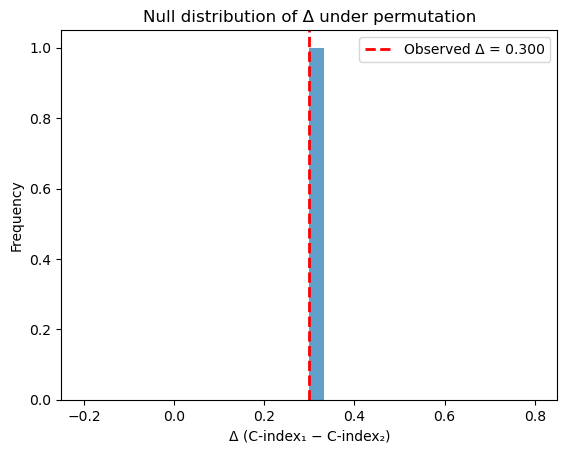

    AI ensemble HR (univariate) AI ensemble p-value (univariate)  \
0  $20663449.024_{(0.000,inf)}$                          1.0e+00   

                       AI ensemble HR (multivariate)  \
0  $7340.342_{(0.000,7297335869681848176366240363...   

  AI ensemble p-value (multivariate)  CAPRA-S HR (univariate)  \
0                            9.5e-01  $1.232_{(0.640,2.373)}$   

  CAPRA-S p-value (univariate)  \
0                      5.3e-01   

                           CAPRA-S HR (multivariate)  \
0  $30.853_{(0.000,127742130663215684994532426690...   

  CAPRA-S p-value (multivariate)  C-index AI ensemble  \
0                        9.5e-01                  0.9   

   C-index CI lower AI ensemble  C-index CI upper AI ensemble  \
0                           1.0                           1.0   

   C-index CAPRA-S  C-index CI lower CAPRA-S  C-index CI upper CAPRA-S  \
0              0.7                   0.75625                   0.99375   

   C-index AI Ensemble + CAPRA-S  C-index 

In [12]:
import os
import json
import logging
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import permutation_test
from sklearn.utils import resample
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from scipy.stats import zscore

# Configuration
np.random.seed(42)
#random = __import__('random')
random.seed(42)
logging.basicConfig(level=logging.INFO)

# Utility Functions
def load_config(config_path):
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

def load_ground_truth(dataset, ground_truth_path):
    file_path = os.path.join(ground_truth_path, f"{dataset}_clinical_standardized_capra_s.csv")
    return pd.read_csv(file_path, dtype={"case_id": str})[['case_id', 'event', 'follow_up_years', 'capra_s_score']]

def zscore_normalize_dict(data):
    values = np.array(list(data.values()))
    std = values.std(ddof=1)
    mean = values.mean()
    return {k: 0 if std == 0 else (v - mean) / std for k, v in data.items()}

def invert_pred_dict(data):
    return {k: -v for k, v in data.items()}

def load_predictions(input_dir, teams, datasets):
    predictions = {}
    for team in teams:
        predictions[team] = {}
        for dataset_dict in datasets:
            dataset = next(iter(dataset_dict))
            dataset_path = os.path.join(input_dir, team, dataset)
            if not os.path.isdir(dataset_path):
                continue

            files = [f for f in os.listdir(dataset_path) if f.endswith('.json')]
            expected = dataset_dict[dataset]
            if len(files) != expected:
                logging.warning(f"{team}/{dataset} expected {expected} preds, found {len(files)}")

            team_preds = {}
            for fn in files:
                cid = fn[:-5]
                with open(os.path.join(dataset_path, fn)) as f:
                    team_preds[cid] = json.load(f)

            if team_preds:
                predictions[team][dataset] = invert_pred_dict(team_preds)
    return predictions

def calculate_p_value_permutation(events, times, preds1, preds2, n_permutations=1, random_state=1):
    def c_index_diff(data1, data2):
        c1 = concordance_index(times, data1, events)
        c2 = concordance_index(times, data2, events)
        return c1 - c2

    result = permutation_test(
        (preds1, preds2),
        statistic=c_index_diff,
        permutation_type='samples',
        n_resamples=n_permutations,
        alternative='two-sided',
        random_state=random_state
    )

    observed_diff = c_index_diff(preds1, preds2)
    p_value = result.pvalue
    return observed_diff, p_value, result.null_distribution

def bootstrap_c_index(events, times, predictions, n_bootstraps):
    original_c_index = concordance_index(times, predictions, events)
    c_index_bootstrap = np.zeros(n_bootstraps)

    for i in range(n_bootstraps):
        indices = resample(range(len(events)), replace=True, n_samples=len(events))
        c_index_bootstrap[i] = concordance_index(times[indices], predictions[indices], events[indices])

    return original_c_index, *np.percentile(c_index_bootstrap, [2.5, 97.5])

def compute_global_cox_metrics(preds_df, gt_df):
    merged = pd.merge(preds_df, gt_df, on='case_id', how='inner')

    df = merged[['prediction', 'capra_s_score', 'follow_up_years', 'event']].copy()

    # AI ensemble only
    data = df[['prediction', 'follow_up_years', 'event']]
    cph = CoxPHFitter().fit(data, 'follow_up_years', 'event')
    c_index, c_index_l, c_index_u = bootstrap_c_index(data['event'], data['follow_up_years'], -cph.predict_partial_hazard(data), 2)

    # CAPRA-S only
    data_c = df[['capra_s_score', 'follow_up_years', 'event']]
    cph_c = CoxPHFitter().fit(data_c, 'follow_up_years', 'event')
    c_index_c, c_index_c_l, c_index_c_u = bootstrap_c_index(data_c['event'], data_c['follow_up_years'], -cph_c.predict_partial_hazard(data_c), 2)

    # Univariate
    uni = CoxPHFitter().fit(data, 'follow_up_years', 'event')
    hr_u_p = uni.hazard_ratios_['prediction']
    lo_u_p, hi_u_p, p_u_p = uni.summary.loc['prediction', ['exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']]

    uni_c = CoxPHFitter().fit(data_c, 'follow_up_years', 'event')
    hr_u_c = uni_c.hazard_ratios_['capra_s_score']
    lo_u_c, hi_u_c, p_u_c = uni_c.summary.loc['capra_s_score', ['exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']]

    # Multivariate
    multi = CoxPHFitter().fit(df[['prediction', 'capra_s_score', 'follow_up_years', 'event']], 'follow_up_years', 'event')
    hr_m_p, lo_m_p, hi_m_p, p_m_p = multi.summary.loc['prediction', ['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']]
    hr_m_c, lo_m_c, hi_m_c, p_m_c = multi.summary.loc['capra_s_score', ['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']]

    c_index_ai_capra, c_index_ai_capra_l, c_index_ai_capra_u = bootstrap_c_index(
        df['event'], df['follow_up_years'], -multi.predict_partial_hazard(df), 2)

    original_diff, p_val, null_diffs = calculate_p_value_permutation(
        df['event'], df['follow_up_years'],
        -multi.predict_partial_hazard(df),
        -cph_c.predict_partial_hazard(data_c)
    )

    plt.hist(null_diffs, bins=30, alpha=0.7)
    plt.axvline(original_diff, color='red', linestyle='--', linewidth=2,
                label=f'Observed Δ = {original_diff:.3f}')
    plt.legend()
    plt.title('Null distribution of Δ under permutation')
    plt.xlabel('Δ (C-index₁ − C-index₂)')
    plt.ylabel('Frequency')
    plt.show()

    return {
        'c_index': c_index, 'c_index_l': c_index_l, 'c_index_u': c_index_u,
        'c_index_c': c_index_c, 'c_index_c_l': c_index_c_l, 'c_index_c_u': c_index_c_u,
        'c_index_ai_capra': c_index_ai_capra, 'c_index_ai_capra_l': c_index_ai_capra_l, 'c_index_ai_capra_u': c_index_ai_capra_u,
        'hr_u_p': hr_u_p, 'lo_u_p': lo_u_p, 'hi_u_p': hi_u_p, 'p_u_p': p_u_p,
        'hr_u_c': hr_u_c, 'lo_u_c': lo_u_c, 'hi_u_c': hi_u_c, 'p_u_c': p_u_c,
        'hr_m_p': hr_m_p, 'lo_m_p': lo_m_p, 'hi_m_p': hi_m_p, 'p_m_p': p_m_p,
        'hr_m_c': hr_m_c, 'lo_m_c': lo_m_c, 'hi_m_c': hi_m_c, 'p_m_c': p_m_c,
        'p_value_permutation_test': p_val,
        'n': len(df)
    }

def format_global_results(vals):
    return pd.DataFrame([{
        'AI ensemble HR (univariate)':      f"${vals['hr_u_p']:.3f}_{{({vals['lo_u_p']:.3f},{vals['hi_u_p']:.3f})}}$",
        'AI ensemble p-value (univariate)': f"{vals['p_u_p']:.1e}",
        'AI ensemble HR (multivariate)':    f"${vals['hr_m_p']:.3f}_{{({vals['lo_m_p']:.3f},{vals['hi_m_p']:.3f})}}$",
        'AI ensemble p-value (multivariate)': f"{vals['p_m_p']:.1e}",
        'CAPRA-S HR (univariate)':      f"${vals['hr_u_c']:.3f}_{{({vals['lo_u_c']:.3f},{vals['hi_u_c']:.3f})}}$",
        'CAPRA-S p-value (univariate)': f"{vals['p_u_c']:.1e}",
        'CAPRA-S HR (multivariate)':    f"${vals['hr_m_c']:.3f}_{{({vals['lo_m_c']:.3f},{vals['hi_m_c']:.3f})}}$",
        'CAPRA-S p-value (multivariate)': f"{vals['p_m_c']:.1e}",
        'C-index AI ensemble': vals['c_index'],
        'C-index CI lower AI ensemble': vals['c_index_l'],
        'C-index CI upper AI ensemble': vals['c_index_u'],
        'C-index CAPRA-S': vals['c_index_c'],
        'C-index CI lower CAPRA-S': vals['c_index_c_l'],
        'C-index CI upper CAPRA-S': vals['c_index_c_u'],
        'C-index AI Ensemble + CAPRA-S': vals['c_index_ai_capra'],
        'C-index CI lower AI Ensemble + CAPRA-S': vals['c_index_ai_capra_l'],
        'C-index CI upper AI Ensemble + CAPRA-S': vals['c_index_ai_capra_u'],
        'The p-value - H0 C-index models CAPRA-S == C-index CAPRA-S+AI ensemble': vals['p_value_permutation_test'],
        'n': vals['n']
    }])

def save_global_results(df, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    df.to_csv(os.path.join(output_dir, 'total_cox_metrics_capra_s_global.csv'), index=False)
    caption = f"Cox PH models on combined datasets (n={df['n'].max()} total cases)."
    with open(os.path.join(output_dir, 'total_cox_metrics_capra_s_global.tex'), 'w') as f:
        f.write(df.drop(columns='n').to_latex(escape=False, caption=caption, label="tab:global_cox"))

def compute_ensemble_coxph(predictions, datasets, ground_truth_path):
    all_events, all_times, all_preds, all_capra_s, all_case_ids = [], [], [], [], []

    for ds_dict in datasets:
        ds = next(iter(ds_dict))
        gt = load_ground_truth(ds, ground_truth_path)
        print('clinical variables:',gt.head())

        combined = {}
        for team, tdata in predictions.items():
            for cid, pred in tdata.get(ds, {}).items():
                combined.setdefault(cid, []).append(pred)

        if not combined:
            continue

        cids = [cid for cid in combined if cid in set(gt['case_id'])]
        if not cids:
            continue

        preds = np.array([combined[cid] for cid in cids])
        sub = gt.set_index('case_id').loc[cids]
        case_ids = sub.index.values
        all_case_ids.extend(case_ids)
        all_events.extend(sub['event'].values)
        all_times.extend(sub['follow_up_years'].values)
        all_capra_s.extend(sub['capra_s_score'].values)
        all_preds.extend(preds)

    raw_preds = np.array(all_preds)
    stds = raw_preds.std(axis=0, ddof=1)
    stds[stds == 0] = 1  # Prevent division by zero
    norm_preds = ((raw_preds - raw_preds.mean(axis=0)) / stds).mean(axis=1)
  

    preds_df = pd.DataFrame({'case_id': all_case_ids, 'prediction': norm_preds})
    gt_df = pd.DataFrame({
        'case_id': all_case_ids,
        'event': all_events,
        'follow_up_years': all_times,
        'capra_s_score': all_capra_s
    })

    return compute_global_cox_metrics(preds_df, gt_df)

def main(config_path):
    cfg = load_config(config_path)
    preds = load_predictions(cfg['input_dir'], cfg['ensemble_teams'], cfg['datasets'])
    raw_results = compute_ensemble_coxph(preds, cfg['datasets'], cfg['clinical_variables'])
    formatted_results = format_global_results(raw_results)
    save_global_results(formatted_results, cfg['output_dir'])
    print(formatted_results)

if __name__ == '__main__':
    config_path = r"C:\Users\khrys\Downloads\leopard-challenge-main-final\leopard-challenge-main\config\config-test.yaml" 
    main(config_path)

---------loaded preditions---------


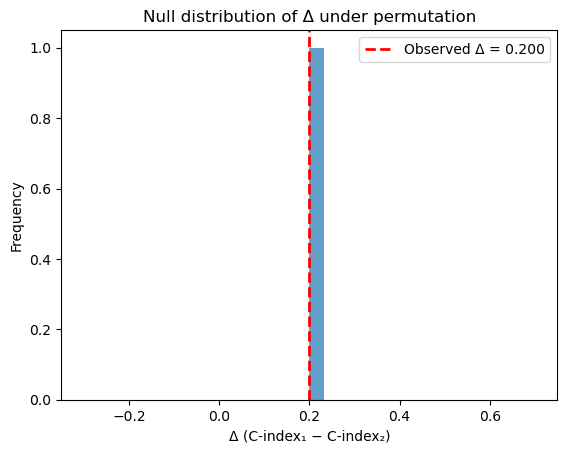

---------computed ensemble---------
    AI ensemble HR (univariate) AI ensemble p-value (univariate)  \
0  $20663449.024_{(0.000,inf)}$                          1.0e+00   

  AI ensemble HR (multivariate) AI ensemble p-value (multivariate)  \
0  $27657006.771_{(0.000,inf)}$                            1.0e+00   

    ISUP HR (univariate) ISUP p-value (univariate)    ISUP HR (multivariate)  \
0  $0.006_{(0.000,inf)}$                   1.0e+00  $3879.334_{(0.000,inf)}$   

  ISUP p-value (multivariate)  C-index AI ensemble  \
0                     1.0e+00                  0.9   

   C-index CI lower AI ensemble  C-index CI upper AI ensemble  C-index ISUP  \
0                      0.878125                      0.996875           0.7   

   C-index CI lower ISUP  C-index CI upper ISUP  C-index AI Ensemble + ISUP  \
0                    0.5                    0.5                         0.9   

   C-index CI lower AI Ensemble + ISUP  C-index CI upper AI Ensemble + ISUP  \
0                  

In [15]:
import os
import json
import logging
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import resample
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from scipy.stats import zscore

# Configuration
np.random.seed(1)
random = __import__('random')
random.seed(1)
logging.basicConfig(level=logging.INFO)

# Utility Functions
def load_config(config_path):
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

def load_ground_truth(dataset, ground_truth_path):
    file_path = os.path.join(ground_truth_path, f"{dataset}_clinical_standardized_capra_s.csv")
    return pd.read_csv(file_path, dtype={"case_id": str})[['case_id', 'event', 'follow_up_years', 'isup']]

def zscore_normalize_dict(data):
    values = np.array(list(data.values()))
    std = values.std(ddof=1)
    mean = values.mean()
    return {k: 0 if std == 0 else (v - mean) / std for k, v in data.items()}

def invert_pred_dict(data):
    return {k: -v for k, v in data.items()}

def load_predictions(input_dir, teams, datasets):
    predictions = {}
    for team in teams:
        predictions[team] = {}
        for dataset_dict in datasets:
            dataset = next(iter(dataset_dict))
            dataset_path = os.path.join(input_dir, team, dataset)
            if not os.path.isdir(dataset_path):
                continue

            files = [f for f in os.listdir(dataset_path) if f.endswith('.json')]
            expected = dataset_dict[dataset]
            if len(files) != expected:
                logging.warning(f"{team}/{dataset} expected {expected} preds, found {len(files)}")

            team_preds = {}
            for fn in files:
                cid = fn[:-5]
                with open(os.path.join(dataset_path, fn)) as f:
                    team_preds[cid] = json.load(f)

            if team_preds:
                predictions[team][dataset] = invert_pred_dict(team_preds)
    return predictions

def calculate_p_value_permutation(events, times, preds1, preds2, n_permutations=1, random_state=1):
    def c_index_diff(data1, data2):
        c1 = concordance_index(times, data1, events)
        c2 = concordance_index(times, data2, events)
        return c1 - c2

    result = permutation_test(
        (preds1, preds2),
        statistic=c_index_diff,
        permutation_type='samples',
        n_resamples=n_permutations,
        alternative='two-sided',
        random_state=random_state
    )

    observed_diff = c_index_diff(preds1, preds2)
    p_value = result.pvalue
    return observed_diff, p_value, result.null_distribution

def bootstrap_c_index(events, times, predictions, n_bootstraps):
    original_c_index = concordance_index(times, predictions, events)
    c_index_bootstrap = np.zeros(n_bootstraps)

    for i in range(n_bootstraps):
        indices = resample(range(len(events)), replace=True, n_samples=len(events))
        c_index_bootstrap[i] = concordance_index(times[indices], predictions[indices], events[indices])

    return original_c_index, *np.percentile(c_index_bootstrap, [2.5, 97.5])

def compute_global_cox_metrics(preds_df, gt_df):
    merged = pd.merge(preds_df, gt_df, on='case_id', how='inner')

    df = merged[['prediction', 'isup', 'follow_up_years', 'event']].copy()

    # AI ensemble only
    data = df[['prediction', 'follow_up_years', 'event']]
    cph = CoxPHFitter().fit(data, 'follow_up_years', 'event')
    c_index, c_index_l, c_index_u = bootstrap_c_index(data['event'], data['follow_up_years'], -cph.predict_partial_hazard(data), 2)

    # ISUP only
    data_c = df[['isup', 'follow_up_years', 'event']]
    cph_c = CoxPHFitter().fit(data_c, 'follow_up_years', 'event')
    c_index_c, c_index_c_l, c_index_c_u = bootstrap_c_index(data_c['event'], data_c['follow_up_years'], -cph_c.predict_partial_hazard(data_c), 2)

    # Univariate
    uni = CoxPHFitter().fit(data, 'follow_up_years', 'event')
    hr_u_p = uni.hazard_ratios_['prediction']
    lo_u_p, hi_u_p, p_u_p = uni.summary.loc['prediction', ['exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']]

    uni_c = CoxPHFitter().fit(data_c, 'follow_up_years', 'event')
    hr_u_c = uni_c.hazard_ratios_['isup']
    lo_u_c, hi_u_c, p_u_c = uni_c.summary.loc['isup', ['exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']]

    # Multivariate
    multi = CoxPHFitter().fit(df[['prediction', 'isup', 'follow_up_years', 'event']], 'follow_up_years', 'event')
    hr_m_p, lo_m_p, hi_m_p, p_m_p = multi.summary.loc['prediction', ['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']]
    hr_m_c, lo_m_c, hi_m_c, p_m_c = multi.summary.loc['isup', ['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']]

    c_index_ai_isup, c_index_ai_isup_l, c_index_ai_isup_u = bootstrap_c_index(
        df['event'], df['follow_up_years'], -multi.predict_partial_hazard(df), 2)

    original_diff, p_val, null_diffs = calculate_p_value_permutation(
        df['event'], df['follow_up_years'],
        -multi.predict_partial_hazard(df),
        -cph_c.predict_partial_hazard(data_c)
    )

    plt.hist(null_diffs, bins=30, alpha=0.7)
    plt.axvline(original_diff, color='red', linestyle='--', linewidth=2,
                label=f'Observed Δ = {original_diff:.3f}')
    plt.legend()
    plt.title('Null distribution of Δ under permutation')
    plt.xlabel('Δ (C-index₁ − C-index₂)')
    plt.ylabel('Frequency')
    plt.show()

    return {
        'c_index': c_index, 'c_index_l': c_index_l, 'c_index_u': c_index_u,
        'c_index_c': c_index_c, 'c_index_c_l': c_index_c_l, 'c_index_c_u': c_index_c_u,
        'c_index_ai_isup': c_index_ai_isup, 'c_index_ai_isup_l': c_index_ai_isup_l, 'c_index_ai_isup_u': c_index_ai_isup_u,
        'hr_u_p': hr_u_p, 'lo_u_p': lo_u_p, 'hi_u_p': hi_u_p, 'p_u_p': p_u_p,
        'hr_u_c': hr_u_c, 'lo_u_c': lo_u_c, 'hi_u_c': hi_u_c, 'p_u_c': p_u_c,
        'hr_m_p': hr_m_p, 'lo_m_p': lo_m_p, 'hi_m_p': hi_m_p, 'p_m_p': p_m_p,
        'hr_m_c': hr_m_c, 'lo_m_c': lo_m_c, 'hi_m_c': hi_m_c, 'p_m_c': p_m_c,
        'p_value_permutation_test': p_val,
        'n': len(df)
    }

def format_global_results(vals):
    return pd.DataFrame([{
        'AI ensemble HR (univariate)':      f"${vals['hr_u_p']:.3f}_{{({vals['lo_u_p']:.3f},{vals['hi_u_p']:.3f})}}$",
        'AI ensemble p-value (univariate)': f"{vals['p_u_p']:.1e}",
        'AI ensemble HR (multivariate)':    f"${vals['hr_m_p']:.3f}_{{({vals['lo_m_p']:.3f},{vals['hi_m_p']:.3f})}}$",
        'AI ensemble p-value (multivariate)': f"{vals['p_m_p']:.1e}",
        'ISUP HR (univariate)':      f"${vals['hr_u_c']:.3f}_{{({vals['lo_u_c']:.3f},{vals['hi_u_c']:.3f})}}$",
        'ISUP p-value (univariate)': f"{vals['p_u_c']:.1e}",
        'ISUP HR (multivariate)':    f"${vals['hr_m_c']:.3f}_{{({vals['lo_m_c']:.3f},{vals['hi_m_c']:.3f})}}$",
        'ISUP p-value (multivariate)': f"{vals['p_m_c']:.1e}",
        'C-index AI ensemble': vals['c_index'],
        'C-index CI lower AI ensemble': vals['c_index_l'],
        'C-index CI upper AI ensemble': vals['c_index_u'],
        'C-index ISUP': vals['c_index_c'],
        'C-index CI lower ISUP': vals['c_index_c_l'],
        'C-index CI upper ISUP': vals['c_index_c_u'],
        'C-index AI Ensemble + ISUP': vals['c_index_ai_isup'],
        'C-index CI lower AI Ensemble + ISUP': vals['c_index_ai_isup_l'],
        'C-index CI upper AI Ensemble + ISUP': vals['c_index_ai_isup_u'],
        'The p-value - H0 C-index models ISUP == C-index ISUP+AI ensemble': vals['p_value_permutation_test'],
        'n': vals['n']
    }])

def save_global_results(df, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    df.to_csv(os.path.join(output_dir, 'total_cox_metrics_isup_s_global.csv'), index=False)
    caption = f"Cox PH models on combined datasets (n={df['n'].max()} total cases)."
    with open(os.path.join(output_dir, 'total_cox_metrics_isup_s_global.tex'), 'w') as f:
        f.write(df.drop(columns='n').to_latex(escape=False, caption=caption, label="tab:global_cox"))

def compute_ensemble_coxph(predictions, datasets, ground_truth_path):
    all_events, all_times, all_preds, all_isup_s, all_case_ids = [], [], [], [], []

    for ds_dict in datasets:
        ds = next(iter(ds_dict))
        gt = load_ground_truth(ds, ground_truth_path)

        combined = {}
        for team, tdata in predictions.items():
            for cid, pred in tdata.get(ds, {}).items():
                combined.setdefault(cid, []).append(pred)

        if not combined:
            continue

        cids = [cid for cid in combined if cid in set(gt['case_id'])]
        if not cids:
            continue

        preds = np.array([combined[cid] for cid in cids])
        sub = gt.set_index('case_id').loc[cids]
        case_ids = sub.index.values
        all_case_ids.extend(case_ids)
        all_events.extend(sub['event'].values)
        all_times.extend(sub['follow_up_years'].values)
        all_isup_s.extend(sub['isup'].values)
        all_preds.extend(preds)

    raw_preds = np.array(all_preds)
    stds = raw_preds.std(axis=0, ddof=1)
    stds[stds == 0] = 1  # Prevent division by zero
    norm_preds = ((raw_preds - raw_preds.mean(axis=0)) / stds).mean(axis=1)
  

    preds_df = pd.DataFrame({'case_id': all_case_ids, 'prediction': norm_preds})
    gt_df = pd.DataFrame({
        'case_id': all_case_ids,
        'event': all_events,
        'follow_up_years': all_times,
        'isup': all_isup_s
    })

    return compute_global_cox_metrics(preds_df, gt_df)

def main(config_path):
    cfg = load_config(config_path)
    preds = load_predictions(cfg['input_dir'], cfg['ensemble_teams'], cfg['datasets'])
    print("---------loaded preditions---------")
    raw_results = compute_ensemble_coxph(preds, cfg['datasets'], cfg['clinical_variables'])
    print("---------computed ensemble---------")
    formatted_results = format_global_results(raw_results)
    save_global_results(formatted_results, cfg['output_dir'])
    print(formatted_results)

if __name__ == '__main__':
    config_path = r"C:\Users\khrys\Downloads\leopard-challenge-main-final\leopard-challenge-main\config\config-test.yaml" 
    main(config_path)

In [27]:
import os
import json
import pandas as pd
import numpy as np
from lifelines.utils import concordance_index
from scipy.stats import bootstrap
import yaml
from sklearn.utils import resample
import matplotlib.pyplot as plt
from scipy.stats import zscore
# Configuration
np.random.seed(42)
#random = __import__('random')
random.seed(42)

# Function to load configuration
def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# Function to load ground truth
def load_ground_truth(dataset, ground_truth_path):
    file_path = f"{ground_truth_path}{dataset}.csv"
    
    return pd.read_csv(file_path, dtype={"case_id": str})

# Function to load predictions
def load_predictions(input_dir, teams, datasets):
    predictions = {}
    for team in teams:
        predictions[team] = {}
        for dataset_dict in datasets:
            
            dataset = list(dataset_dict.keys())[0]
            dataset_path = os.path.join(input_dir, team, dataset)
            if not os.path.exists(dataset_path):
                continue  # Skip if directory does not exist
            team_dataset_preds = {}
            

            if len(os.listdir(dataset_path)) == list(dataset_dict.values())[0]:
                for file_name in os.listdir(dataset_path):
                    if file_name.endswith('.json'):
                        case_id = file_name.replace('.json', '')
                        with open(os.path.join(dataset_path, file_name), 'r') as f:
                            team_dataset_preds[case_id] = json.load(f)
            else:
                print(f"Dataset {dataset} predictions for team {team} are incomplete, expected {list(dataset_dict.values())[0]} files, found {len(os.listdir(dataset_path))} files")
            #print('loaded dataset',dataset)
            if team_dataset_preds:  # Ensure predictions are not empty
                #print(team_dataset_preds.shape)
                
                predictions[team][dataset] = team_dataset_preds
            #print('predictions[team][dataset]',len(predictions[team][dataset]))
    return predictions

# Function to compute ensemble and individual C-indexes
def compute_c_indexes(predictions, datasets, ground_truth_path):
    results = []
    for dataset_dict in datasets:
        dataset = list(dataset_dict.keys())[0]
        ground_truth = load_ground_truth(dataset, ground_truth_path)
        ground_truth = ground_truth.sort_values(by='case_id', ascending=True)

        valid_case_ids = ground_truth['case_id'].tolist()
        #print('valid_case_ids',valid_case_ids)
        all_preds = {}
        team_c_indexes = {}

        for team, team_data in predictions.items():
            if dataset not in team_data or not team_data[dataset]:
                continue
            
            preds = team_data[dataset]
            #print("preds",preds)
       
            #case_ids = [case_id for case_id in preds.keys() if case_id in valid_case_ids]
            case_values_bf = np.array([preds[case_id] for case_id in valid_case_ids])
            #print("case_values_bf")
            #plt.hist(case_values_bf)
            #plt.show()
        
        
            case_values = zscore(np.array([preds[case_id] for case_id in valid_case_ids]))
            #print("case_values")
            #plt.hist(case_values)
            #plt.show()
        

            #print("case_values",case_values)
            if len(case_values) == 0:
                continue
            
            for case_id, value in zip(valid_case_ids, case_values):
                #print('in  loop',case_id, value)
                if case_id not in all_preds:
                    all_preds[case_id] = []
                all_preds[case_id].append(value)
            #print("all_preds",all_preds)

            ground_truth_filtered = ground_truth[ground_truth['case_id'].isin(valid_case_ids)].copy()
            if not ground_truth_filtered.empty:
                c_index, ci_lower, ci_upper = bootstrap_c_index(
                    ground_truth_filtered['event'].values,
                    ground_truth_filtered['follow_up_years'].values,
                    case_values,
                    n_bootstraps=2
                )
                team_c_indexes[team] = {'c_index': c_index, 'ci_lower': ci_lower, 'ci_upper': ci_upper}

        if not all_preds:
            continue

        #case_ids = list(all_preds.keys())
        ensemble_risks=[]

        ensemble_risks = np.array([np.mean(pred_list) for pred_list in all_preds.values()])
        ground_truth_filtered = ground_truth[ground_truth['case_id'].isin(valid_case_ids)].copy()
        if ground_truth_filtered.empty:
            continue
        
        ground_truth_filtered['ensemble_risk'] = ensemble_risks
        num_cases = len(valid_case_ids)

        # Compute ensemble C-index
        ensemble_c_index, ensemble_ci_lower, ensemble_ci_upper = bootstrap_c_index(
            ground_truth_filtered['event'].values,
            ground_truth_filtered['follow_up_years'].values,
            ground_truth_filtered['ensemble_risk'].values,
            n_bootstraps=2
        )

        result_entry = {
            '#cases': num_cases,
            'dataset': dataset,
            'ensemble_c_index': ensemble_c_index,
            'ci_lower': ensemble_ci_lower,
            'ci_upper': ensemble_ci_upper
        }

        for team, metrics in team_c_indexes.items():
            result_entry[f'{team}_c_index'] = metrics['c_index']
            result_entry[f'{team}_ci_lower'] = metrics['ci_lower']
            result_entry[f'{team}_ci_upper'] = metrics['ci_upper']
        
        results.append(result_entry)

    return pd.DataFrame(results) if results else pd.DataFrame(columns=['dataset', 'ensemble_c_index', 'ci_lower', 'ci_upper'])

# Function to compute bootstrap C-index
def bootstrap_c_index(events, times, predictions, n_bootstraps):
    original_c_index = concordance_index(times, predictions, events)
    c_index_bootstrap = np.zeros(n_bootstraps)

    for i in range(n_bootstraps):
        indices = resample(range(len(events)), replace=True, n_samples=len(events))
        c_index_bootstrap[i] = concordance_index(times[indices], predictions[indices], events[indices])

    ci_lower, ci_upper = np.percentile(c_index_bootstrap, [2.5, 97.5])
    print('original_c_index',original_c_index)
    print('ci_lower, ci_upper',ci_lower, ci_upper)
    return original_c_index, ci_lower, ci_upper

# Function to save results
def save_results(results, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    csv_path = os.path.join(output_dir, 'c_index_ensemble_results.csv')
    latex_path = os.path.join(output_dir, 'c_index_ensemble_results.tex')
    
    results.to_csv(csv_path, index=False)
    with open(latex_path, 'w') as f:
        f.write(results.to_latex(index=False))

# Main function
def main(config_path):
    config = load_config(config_path)
    predictions = load_predictions(config['input_dir'], config['ensemble_teams'], config['datasets'])
    results = compute_c_indexes(predictions, config['datasets'], config['ground_truth_path'])
    print(results)
    save_results(results, config['output_dir'])

if __name__ == '__main__':
    import sys
    config_path = r"C:\Users\khrys\Downloads\leopard-challenge-main-final\leopard-challenge-main\config\config-test.yaml"
    main(config_path)

original_c_index 0.9
ci_lower, ci_upper 1.0 1.0
original_c_index 0.9
ci_lower, ci_upper 0.801875 0.873125
original_c_index 0.9
ci_lower, ci_upper 0.5107142857142857 0.9178571428571429
original_c_index 0.9
ci_lower, ci_upper 1.0 1.0
original_c_index 0.9
ci_lower, ci_upper 0.753125 0.871875
original_c_index 0.9
ci_lower, ci_upper 0.75625 0.99375
   #cases  dataset  ensemble_c_index  ci_lower  ci_upper  \
0       5  radboud               0.9   0.75625   0.99375   

   mevis_updated_c_index  mevis_updated_ci_lower  mevis_updated_ci_upper  \
0                    0.9                     1.0                     1.0   

   martellab_2_c_index  martellab_2_ci_lower  martellab_2_ci_upper  \
0                  0.9              0.801875              0.873125   

   paicon_2_c_index  paicon_2_ci_lower  paicon_2_ci_upper  \
0               0.9           0.510714           0.917857   

   airamatrix_1_c_index  airamatrix_1_ci_lower  airamatrix_1_ci_upper  \
0                   0.9                    

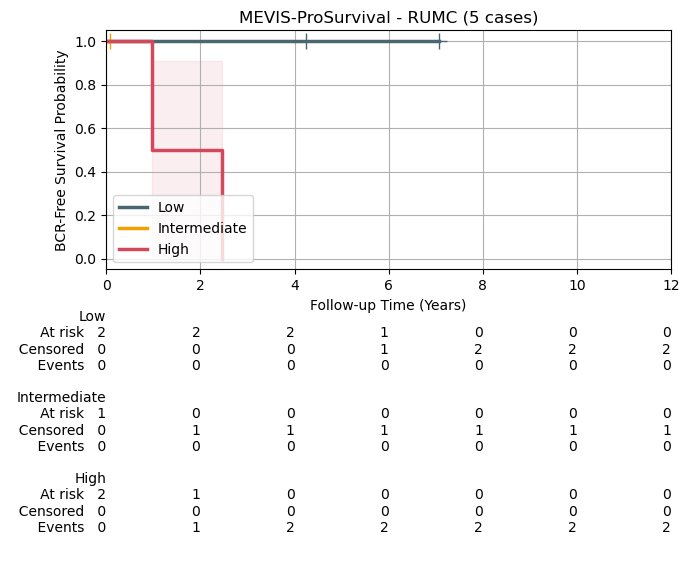

<Figure size 640x480 with 0 Axes>

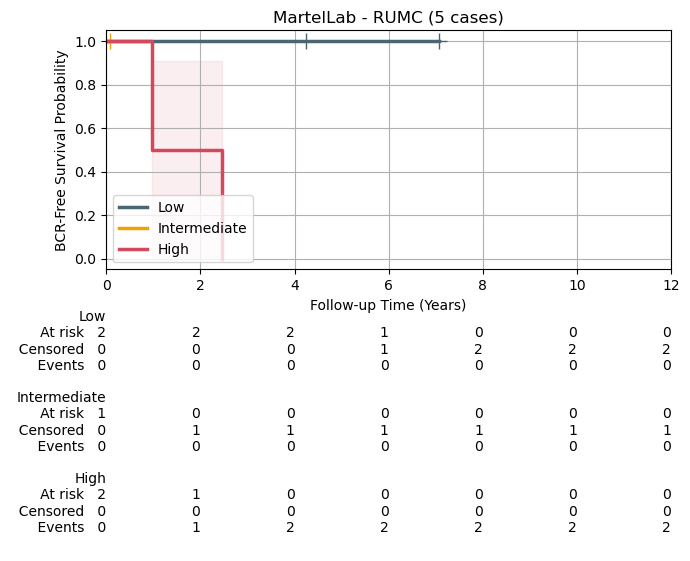

<Figure size 640x480 with 0 Axes>

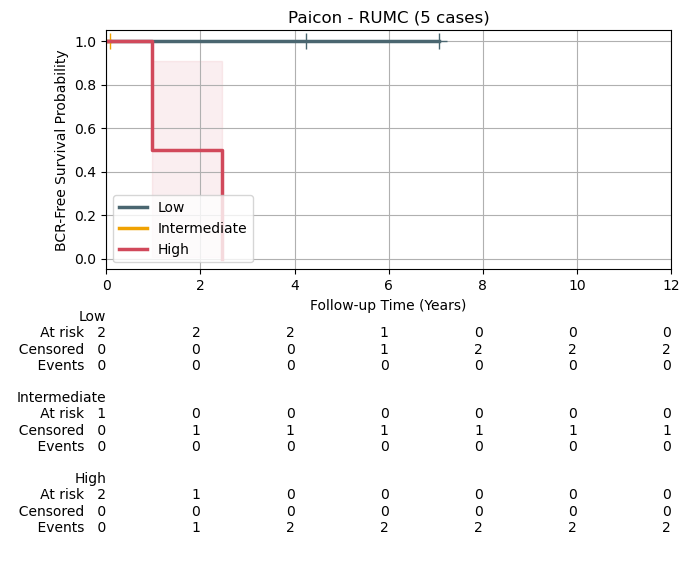

<Figure size 640x480 with 0 Axes>

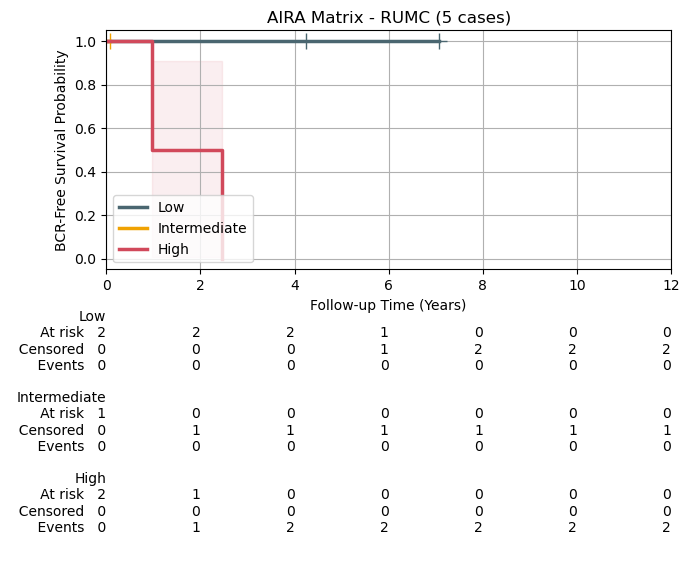

<Figure size 640x480 with 0 Axes>

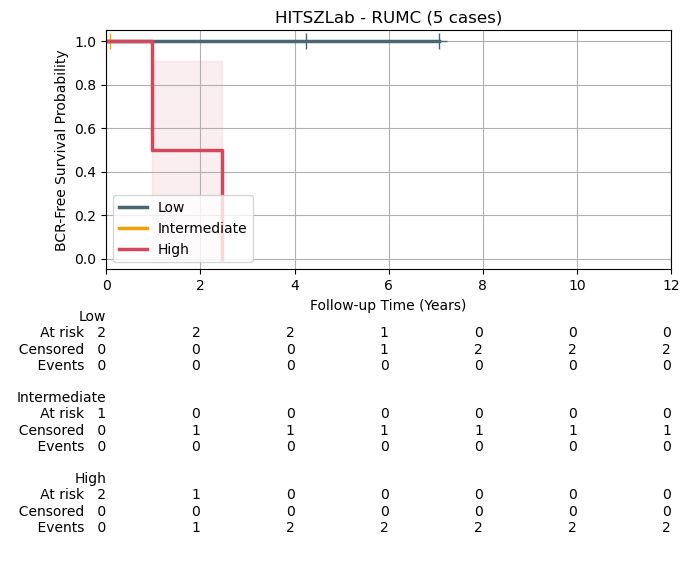

In [19]:
import os
import json
import yaml
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, statistics
import matplotlib
matplotlib.use('Agg')  # Add this line
import matplotlib.pyplot as plt
%matplotlib inline
from lifelines.plotting import add_at_risk_counts


# Load configuration file
def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# Read ground truth data
def load_ground_truth(ground_truth_path):
    return pd.read_csv(ground_truth_path, dtype={"case_id": str})

# Read team predictions
def load_predictions(team, dataset, input_path):
    team_path = os.path.join(input_path, team, dataset)
    predictions = {}
    for file in os.listdir(team_path):
        if file.endswith('.json'):
            case_id = file.replace('.json', '')
            with open(os.path.join(team_path, file), 'r') as f:
                predictions[case_id] = json.load(f)
    return predictions

# Assign risk groups
def assign_risk_groups(predictions):
    values = np.array(list(predictions.values()))
    low_thresh = np.percentile(values, 33)
    high_thresh = np.percentile(values, 66)
    risk_groups = {}
    
    for case_id, time in predictions.items():
        if time <= low_thresh:
            risk_groups[case_id] = 'High'
        elif time <= high_thresh:
            risk_groups[case_id] = 'Intermediate'
        else:
            risk_groups[case_id] = 'Low'
    
    return risk_groups

# Plot all Kaplan-Meier curves in a grid

def plot_all_kaplan_meier(config):
    teams = config['teams']
    team_names = config['team_names']
    dataset_names = config['dataset_names']
    datasets = [list(dataset_dict.keys())[0] for dataset_dict in config['datasets']]
    dataset_x_limits = {"cologne": (0, 6), "brazil": (0, 6), "plco": (0, 14), "radboud": (0, 12)}
    colors = {'High': '#D1495B', 'Intermediate': '#f0a202', 'Low': '#4A6670'}

    for team in teams:
        fig, axes = plt.subplots(1, len(datasets), figsize=(7 * len(datasets), 6), sharey=True)

        if len(datasets) == 1:
            axes = [axes]  # ensure axes is iterable

        for j, dataset in enumerate(datasets):
            ground_truth = load_ground_truth(os.path.join(config['ground_truth_path'], dataset + ".csv"))
            predictions = load_predictions(team, dataset, config['input_dir'])
            risk_groups = assign_risk_groups(predictions)

            kmfs = {}
            ax = axes[j]

            for group in ['Low', 'Intermediate', 'High']:
                mask = ground_truth['case_id'].isin([k for k, v in risk_groups.items() if v == group])
                group_data = ground_truth[mask]

                if len(group_data) > 0:
                    kmf = KaplanMeierFitter()
                    kmf.fit(group_data['follow_up_years'], event_observed=group_data['event'], label=group)
                    kmf.plot_survival_function(ax=ax, color=colors[group],lw=2.5, ci_alpha=0.09, show_censors=True)
                    kmfs[group] = kmf

            ax.set_title(f'{team_names[team]} - {dataset_names[dataset]} ({len(ground_truth)} cases)')
            ax.set_xlabel('Follow-up Time (Years)')
            ax.set_ylabel('BCR-Free Survival Probability')
            ax.legend(loc='lower left')
            ax.grid(True)


            if dataset in dataset_x_limits:
                ax.set_xlim(dataset_x_limits[dataset])

            # Add at risk counts properly
            if kmfs:
                add_at_risk_counts(*kmfs.values(), ax=ax)

        plt.tight_layout()
        output_path = os.path.join(config['output_dir'], f'kaplan_meier_{team}.png')
        plt.show()
        plt.savefig(output_path)
        plt.close(fig)
        


# Main execution function
def main(config_path):
    config = load_config(config_path)
    plot_all_kaplan_meier(config)
    
if __name__ == '__main__':
    main(r"C:\Users\khrys\Downloads\leopard-challenge-main-final\leopard-challenge-main\config\config-test.yaml")

dataset: radboud counts: {'Low': 2, 'High': 2, 'Intermediate': 1}


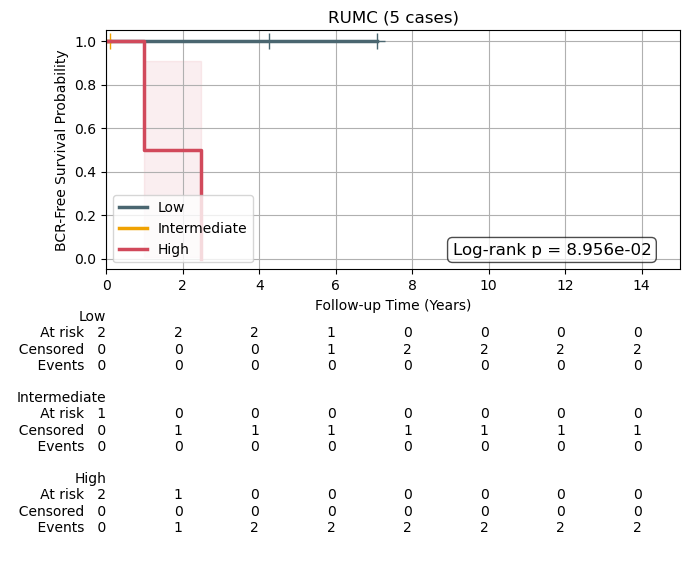

<Figure size 640x480 with 0 Axes>

In [21]:
import os
import json
import yaml  # fixed import
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test  # added import
import matplotlib
matplotlib.use('Agg')  # Headless backend
import matplotlib.pyplot as plt
from lifelines.plotting import add_at_risk_counts
%matplotlib inline

# Load configuration file
def load_config(config_path):
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

# Read ground truth data
def load_ground_truth(ground_truth_path):
    return pd.read_csv(ground_truth_path, dtype={"case_id": str})

# Read team predictions into a DataFrame
def load_all_predictions(teams, dataset, input_dir):
    dfs = []
    for team in teams:
        team_path = os.path.join(input_dir, team, dataset)
        preds = {}
        for fname in os.listdir(team_path):
            if fname.endswith('.json'):
                case_id = fname.replace('.json', '')
                with open(os.path.join(team_path, fname), 'r') as f:
                    preds[case_id] = json.load(f)
        df = pd.Series(preds, name=team)
        dfs.append(df)
    return pd.concat(dfs, axis=1)

# Assign risk groups given explicit thresholds
def assign_risk_groups(scores, low_thresh, high_thresh):
    risk = {}
    for case_id, val in scores.items():
        if val <= low_thresh:
            risk[case_id] = 'High'
        elif val <= high_thresh:
            risk[case_id] = 'Intermediate'
        else:
            risk[case_id] = 'Low'
    return risk

# Plot ensemble Kaplan-Meier curves across datasets with log-rank p-values at bottom
# Using cutoff thresholds 

def plot_ensemble_kaplan_meier(config):
    teams = config['ensemble_teams']
    dataset_names = config['dataset_names']
    datasets = list(dataset_names.keys())
    dataset_x_limits = {"cologne": (0, 6), "brazil": (0, 6), "plco": (0, 15), "radboud": (0, 15)}
    colors = {'High': '#D1495B', 'Intermediate': '#f0a202', 'Low': '#4A6670'}

  

    fig, axes = plt.subplots(1, len(datasets), figsize=(7 * len(datasets), 6), sharey=True)
    if len(datasets) == 1:
        
        axes = [axes]

    for ax, dataset in zip(axes, datasets):
        # Load truth and predictions
        gt = load_ground_truth(os.path.join(config['ground_truth_path'], f"{dataset}.csv"))
        preds_df = load_all_predictions(teams, dataset, config['input_dir'])

        # Z-score normalize per team across cases
        preds_z = preds_df.apply(lambda col: (col - col.mean()) / col.std(), axis=0)
        # Ensemble: mean per case
        ensemble_scores = preds_z.mean(axis=1)
        
        #fig, axes = plt.subplots(1, 1, figsize=(7 * len(datasets), 6))
       
        #plt.hist(ensemble_scores)
        #plt.axvline(x=low_thresh,color='red', linestyle='--', linewidth=2)
        #plt.axvline(x=high_thresh,color='red', linestyle='--', linewidth=2)        
        #plt.show()

        # Assign risk groups using Radboud thresholds
        low_thresh = ensemble_scores.quantile(0.33)
        high_thresh = ensemble_scores.quantile(0.66)
        risk_groups = assign_risk_groups(ensemble_scores, low_thresh, high_thresh)
        
        counts = {}
        for item in list(risk_groups.values()):
            counts[item] = counts.get(item, 0) + 1
        print('dataset:',dataset,'counts:',counts)

        # Fit and plot KM curves
        kmfs = {}
        for group in ['Low', 'Intermediate', 'High']:
            case_ids = [cid for cid, grp in risk_groups.items() if grp == group]
            mask = gt['case_id'].isin(case_ids)
            data_grp = gt[mask]
            if not data_grp.empty:
                kmf = KaplanMeierFitter()
                kmf.fit(data_grp['follow_up_years'], event_observed=data_grp['event'], label=group)
                kmf.plot_survival_function(ax=ax, color=colors[group], lw=2.5, ci_alpha=0.09, show_censors=True)
                kmfs[group] = kmf

        # Log-rank test between High and Low risk groups
        high_ids = [cid for cid, grp in risk_groups.items() if grp == 'High']
        low_ids = [cid for cid, grp in risk_groups.items() if grp == 'Low']
        data_high = gt[gt['case_id'].isin(high_ids)]
        data_low = gt[gt['case_id'].isin(low_ids)]
   
        if not data_high.empty and not data_low.empty:
            result = logrank_test(
                data_high['follow_up_years'], data_low['follow_up_years'],
                event_observed_A=data_high['event'], event_observed_B=data_low['event']
            )
            p = result.p_value
            ax.text(
                0.95, 0.05, f"Log-rank p = {p:.3e}",
                transform=ax.transAxes, ha='right', va='bottom', fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.7)
            )

        ax.set_title(f"{dataset_names[dataset]} ({len(gt)} cases)")
        ax.set_xlabel('Follow-up Time (Years)')
        ax.set_ylabel('BCR-Free Survival Probability')
        ax.legend(loc='lower left')
        ax.grid(True)
        

        if dataset in dataset_x_limits:
            ax.set_xlim(dataset_x_limits[dataset])

        if kmfs:
            add_at_risk_counts(*kmfs.values(), ax=ax)

    plt.tight_layout()
    out = os.path.join(config['output_dir'], 'kaplan_meier_ensemble_with_pvalue.png')
    plt.show()
    plt.savefig(out)
    plt.close(fig)
    plt.show()


# Main

def main(config_path):
    config = load_config(config_path)
    plot_ensemble_kaplan_meier(config)

if __name__ == '__main__':
    main(r"C:\Users\khrys\Downloads\leopard-challenge-main-final\leopard-challenge-main\config\config-test.yaml")

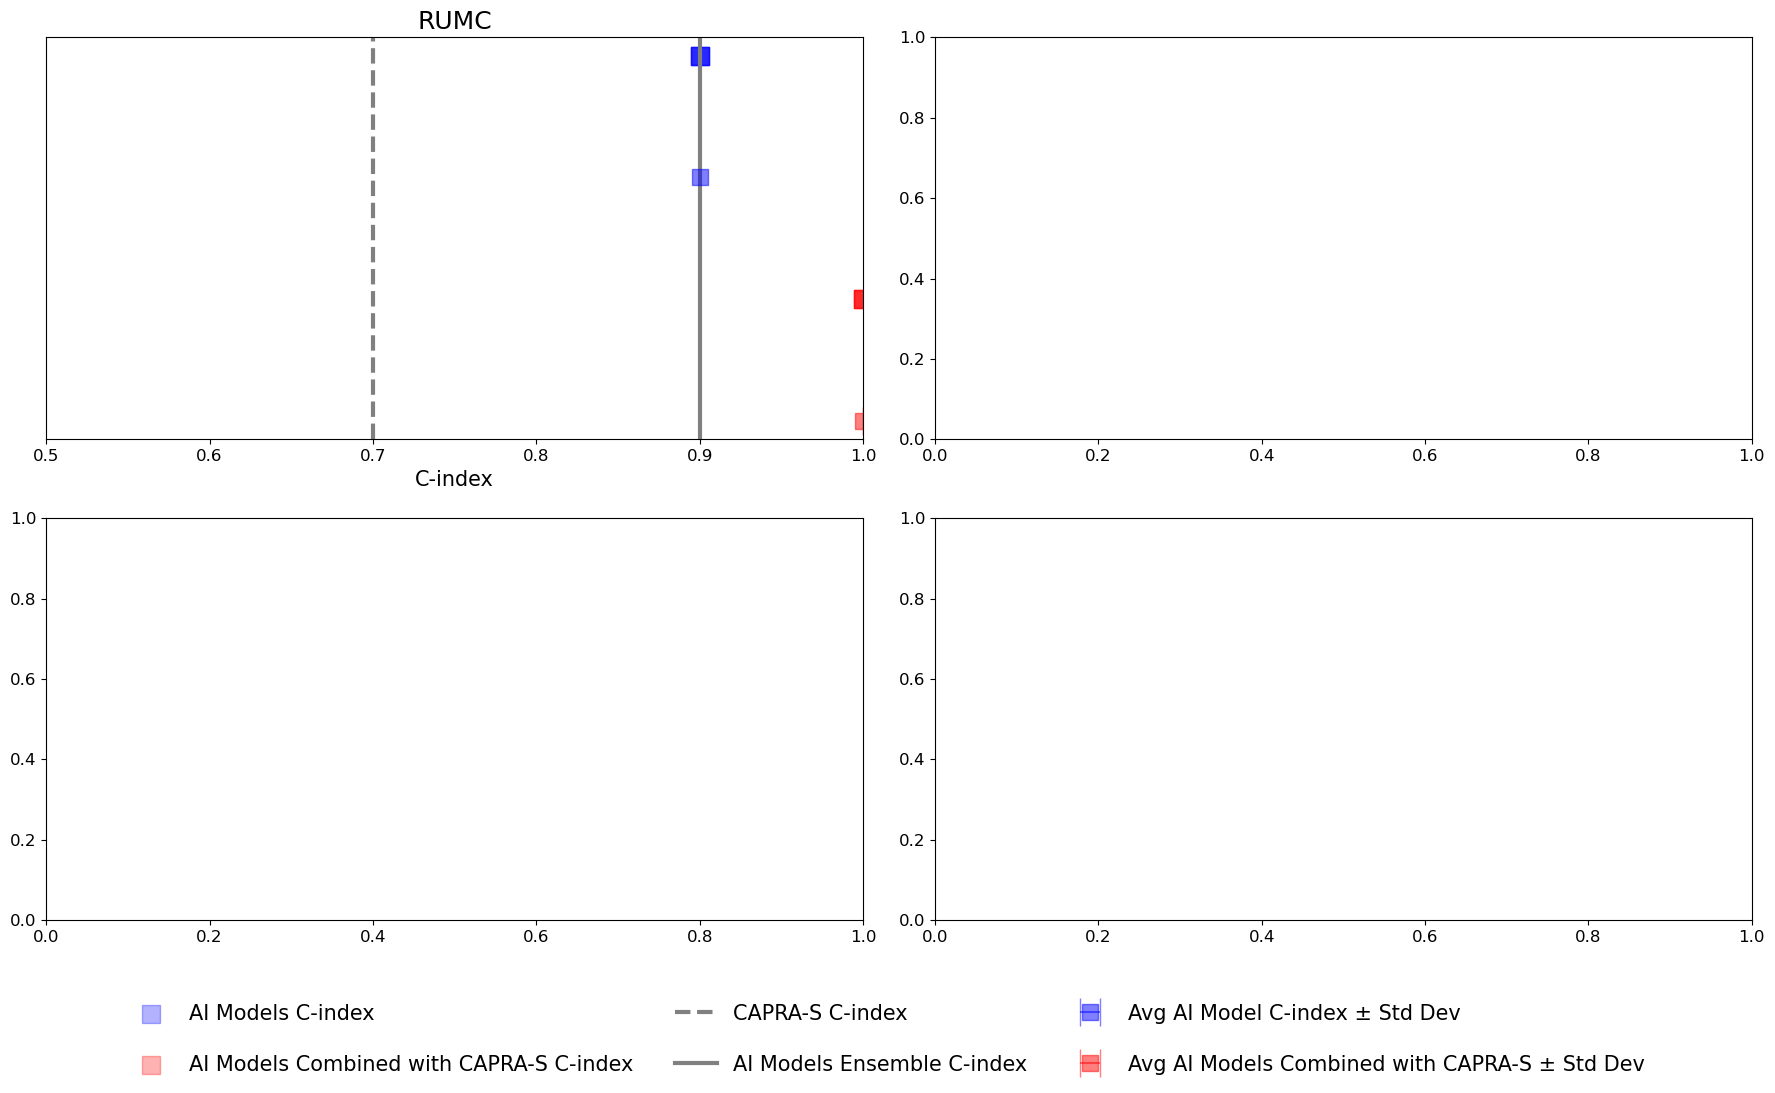

In [30]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml

# Load configuration file
def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

def plot_dataset(ax, dataset, dataset_name, team_scores, capra_scores, capra_pathologist_score, ensemble_score, title):
    # Plot team predictions (transparent blue squares)
    ax.scatter(team_scores, [1] * len(team_scores), color='blue', alpha=0.3, s=150, marker='s', label='AI Models C-index')
    
    # Plot average team prediction with std error bar
    mean_team = np.mean(team_scores)
    std_team = np.std(team_scores)
    ax.errorbar(mean_team, 0.8, xerr=std_team, fmt='s', color='blue', alpha=0.5, markersize=11, capsize=10, label='Avg AI Model C-index ± Std Dev')
    
    # Plot team combined CAPRA predictions (transparent red squares)
    ax.scatter(capra_scores, [0.6] * len(capra_scores), color='red', alpha=0.3, s=150, marker='s', label='AI Models Combined with CAPRA-S C-index')
    
    # Plot average team combined CAPRA with std error bar
    mean_capra = np.mean(capra_scores)
    std_capra = np.std(capra_scores)
    ax.errorbar(mean_capra, 0.4, xerr=std_capra, fmt='s', color='red', alpha=0.5, markersize=11, capsize=10, label='Avg AI Models Combined with CAPRA-S ± Std Dev')
    
    # Plot CAPRA-S pathologist c-index as vertical grey dashed line
    ax.axvline(capra_pathologist_score, color='grey', linestyle='--', label='CAPRA-S C-index', linewidth=3)
    
    # Plot Ensemble c-index as grey solid vertical line
    ax.axvline(ensemble_score, color='grey', linestyle='-', label='AI Models Ensemble C-index', linewidth=3)
    
    ax.set_yticks([])
    ax.set_xlim(0.5, 1.0)
    ax.set_title(title, fontsize=18)  # Increased title font size
    ax.set_xlabel("C-index", fontsize=15)  # Increased x-axis label font size
    ax.tick_params(axis='x', labelsize=12)  # Increased x-tick label size


def main(config_path):
    # Load data from CSV files
    config = load_config(config_path)
    
    team_predictions = pd.read_csv(os.path.join(config["output_dir"], "c_index_results.csv"))
    team_combined_capra = pd.read_csv(os.path.join(config["output_dir"], "c_index_model_capra_s_combined_results.csv"))
    pathologist_capra = pd.read_csv(os.path.join(config["output_dir"], "c_index_capra_results.csv"))
    team_ensemble = pd.read_csv(os.path.join(config["output_dir"], "c_index_ensemble_results.csv"))

    datasets = ["radboud"]#, "plco", "brazil", "cologne"]
    dataset_names = config["dataset_names"]
    
    # Set global font size (double the default, e.g., if default is ~10, set to 20)
    plt.rcParams.update({
        'font.size': 15,
        'axes.titlesize': 18,
        'axes.labelsize': 15,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12
    })

    # Create 4 plots, one for each dataset
    fig, axs = plt.subplots(2, 2, figsize=(18, 14))  # Increased figure size slightly for better spacing
    axs = axs.flatten()
    
    for i, dataset in enumerate(datasets):
        dataset_name = dataset_names[dataset]
        
        # Extract scores
        team_scores = team_predictions[dataset_name + '_c_index'].dropna().values
        capra_scores = team_combined_capra[dataset_name].dropna().values
        capra_pathologist_score = pathologist_capra[pathologist_capra["dataset"] == dataset]["c_index"].item()
        ensemble_score = team_ensemble[team_ensemble["dataset"] == dataset]["ensemble_c_index"].item()
        
        # Plot each dataset in separate subplot
        plot_dataset(
            axs[i],
            dataset,
            dataset_name,
            team_scores,
            capra_scores,
            capra_pathologist_score,
            ensemble_score,
            dataset_name
        )
    
    # Collect handles and labels from the first axis (assuming all axes have the same labels)
    handles, labels = axs[0].get_legend_handles_labels()

    # Adjust layout so legend fits
    fig.tight_layout(rect=[0, 0.05, 1, 0.75])  # Adjusted to leave more space at bottom for legend

    # Add shared legend below all subplots with larger font and double spacing
    fig.legend(
        handles, labels,
        loc='lower center',
        ncol=3,
        fontsize=15,  # Doubled legend font size
        frameon=False,
        bbox_to_anchor=(0.5, -0.04),  # Adjusted for better positioning
        labelspacing=1.5  # Double line spacing
    )

    # Save and show plot
    plt.savefig(os.path.join(config["output_dir"], "detailed_c_index_capra_plots.png"), bbox_inches='tight')
    plt.show()

if __name__ == '__main__':
    main(r"C:\Users\khrys\Downloads\leopard-challenge-main-final\leopard-challenge-main\config\config-test.yaml")

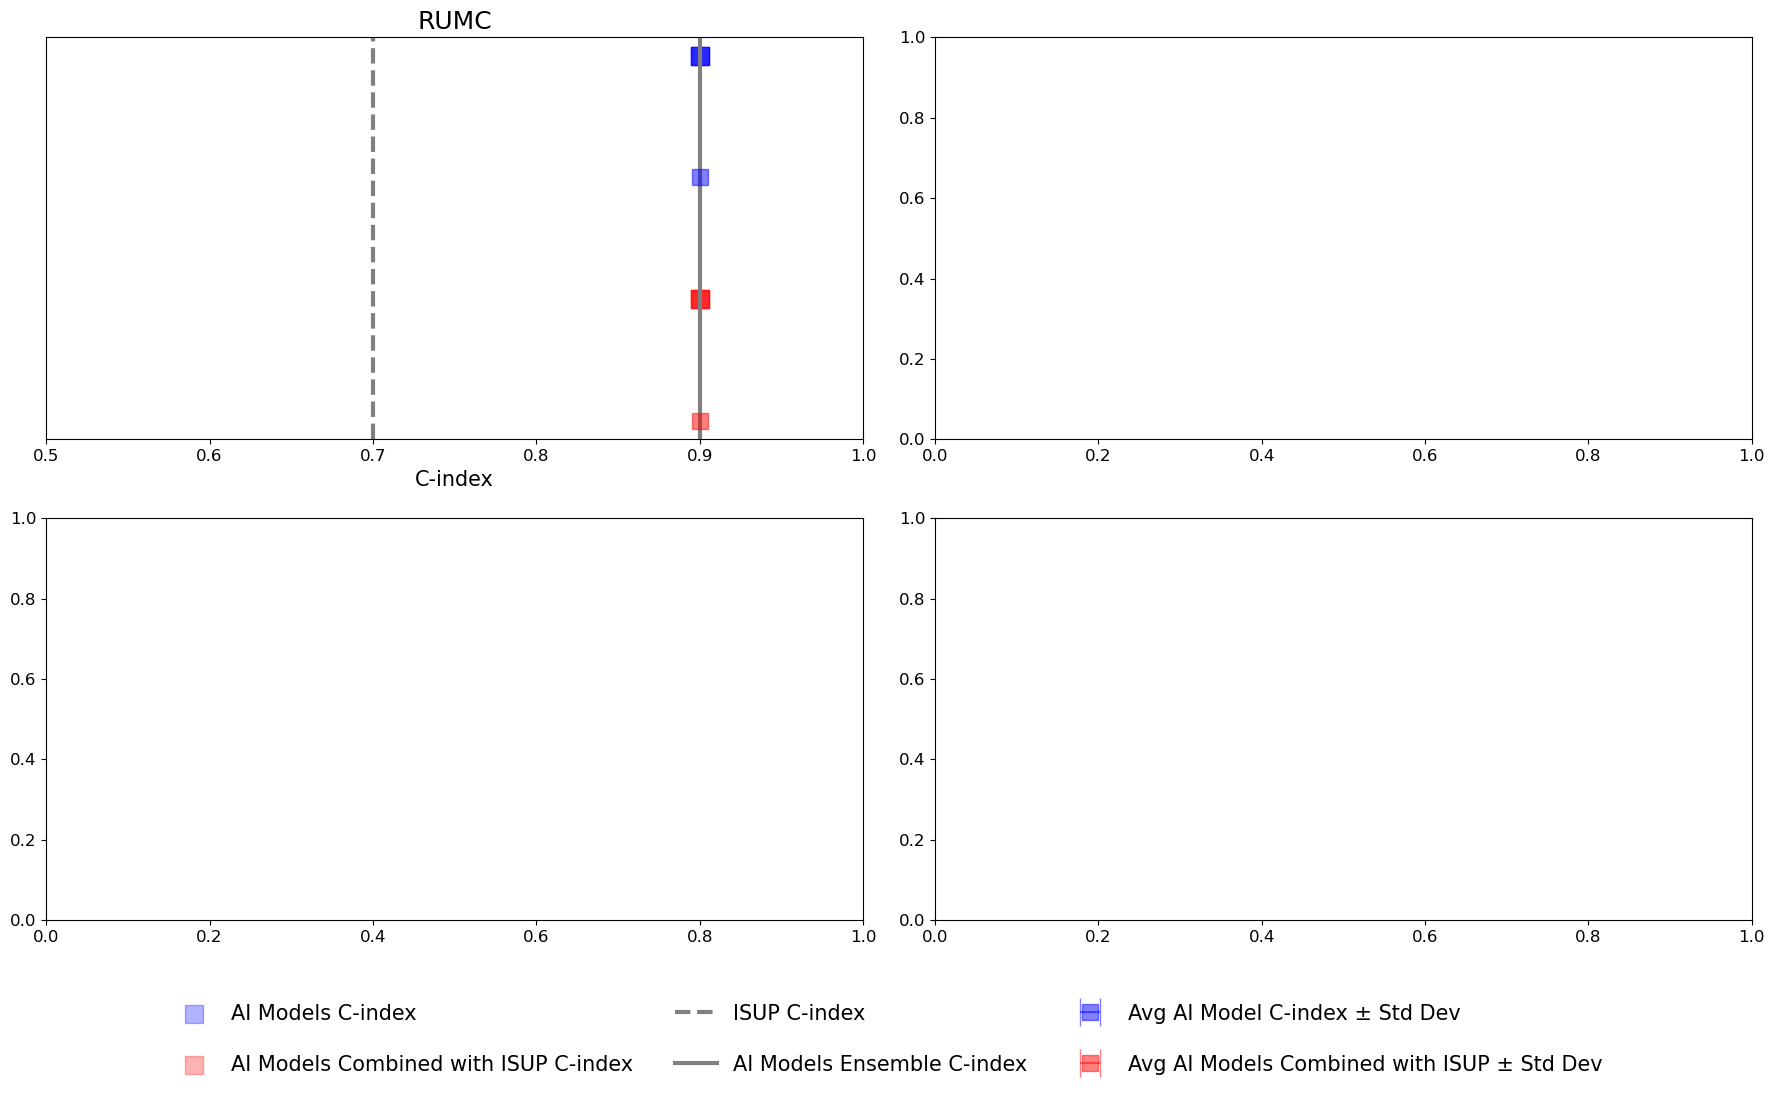

In [35]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml

# Load configuration file
def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

def plot_dataset(ax, dataset, dataset_name, team_scores, isup_scores, isup_pathologist_score, ensemble_score, title):
    # Plot team predictions (transparent blue squares)
    ax.scatter(team_scores, [1] * len(team_scores), color='blue', alpha=0.3, s=150, marker='s', label='AI Models C-index')
    
    # Plot average team prediction with std error bar
    mean_team = np.mean(team_scores)
    std_team = np.std(team_scores)
    ax.errorbar(mean_team, 0.8, xerr=std_team, fmt='s', color='blue', alpha=0.5, markersize=11, capsize=10, label='Avg AI Model C-index ± Std Dev')
    
    # Plot team combined ISUP predictions (transparent red squares)
    ax.scatter(isup_scores, [0.6] * len(isup_scores), color='red', alpha=0.3, s=150, marker='s', label='AI Models Combined with ISUP C-index')
    
    # Plot average team combined ISUP with std error bar
    mean_isup = np.mean(isup_scores)
    std_isup = np.std(isup_scores)
    ax.errorbar(mean_isup, 0.4, xerr=std_isup, fmt='s', color='red', alpha=0.5, markersize=11, capsize=10, label='Avg AI Models Combined with ISUP ± Std Dev')
    
    # Plot ISUP pathologist c-index as vertical grey dashed line
    ax.axvline(isup_pathologist_score, color='grey', linestyle='--', label='ISUP C-index', linewidth=3)
    
    # Plot Ensemble c-index as grey solid vertical line
    ax.axvline(ensemble_score, color='grey', linestyle='-', label='AI Models Ensemble C-index', linewidth=3)
    
    ax.set_yticks([])
    ax.set_xlim(0.5, 1.0)
    ax.set_title(title, fontsize=18)  # Increased title font size
    ax.set_xlabel("C-index", fontsize=15)  # Increased x-axis label font size
    ax.tick_params(axis='x', labelsize=12)  # Increased x-tick label size


def main(config_path):
    # Load data from CSV files
    config = load_config(config_path)
    
    team_predictions = pd.read_csv(os.path.join(config["output_dir"], "c_index_results.csv"))
    team_combined_isup = pd.read_csv(os.path.join(config["output_dir"], "c_index_model_isup_combined_results.csv"))
    pathologist_isup = pd.read_csv(os.path.join(config["output_dir"], "c_index_isup_results.csv"))
    team_ensemble = pd.read_csv(os.path.join(config["output_dir"], "c_index_ensemble_results.csv"))

    datasets = ["radboud"]#, "plco", "brazil", "cologne"]
    dataset_names = config["dataset_names"]
    
    # Set global font size (double the default, e.g., if default is ~10, set to 20)
    plt.rcParams.update({
        'font.size': 15,
        'axes.titlesize': 18,
        'axes.labelsize': 15,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12
    })

    # Create 4 plots, one for each dataset
    fig, axs = plt.subplots(2, 2, figsize=(18, 14))  # Increased figure size slightly for better spacing
    axs = axs.flatten()
    
    for i, dataset in enumerate(datasets):
        dataset_name = dataset_names[dataset]
        
        # Extract scores
        team_scores = team_predictions[dataset_name + '_c_index'].dropna().values
        isup_scores = team_combined_isup[dataset_name].dropna().values
        isup_pathologist_score = pathologist_isup[pathologist_isup["dataset"] == dataset]["c_index"].item()
        ensemble_score = team_ensemble[team_ensemble["dataset"] == dataset]["ensemble_c_index"].item()
        
        # Plot each dataset in separate subplot
        plot_dataset(
            axs[i],
            dataset,
            dataset_name,
            team_scores,
            isup_scores,
            isup_pathologist_score,
            ensemble_score,
            dataset_name
        )
    
    # Collect handles and labels from the first axis (assuming all axes have the same labels)
    handles, labels = axs[0].get_legend_handles_labels()

    # Adjust layout so legend fits
    fig.tight_layout(rect=[0, 0.05, 1, 0.75])  # Adjusted to leave more space at bottom for legend

    # Add shared legend below all subplots with larger font and double spacing
    fig.legend(
        handles, labels,
        loc='lower center',
        ncol=3,
        fontsize=15,  # Doubled legend font size
        frameon=False,
        bbox_to_anchor=(0.5, -0.04),  # Adjusted for better positioning
        labelspacing=1.5  # Double line spacing
    )

    # Save and show plot
    plt.savefig(os.path.join(config["output_dir"], "detailed_c_index_plots.png"), bbox_inches='tight')
    plt.show()

if __name__ == '__main__':
    main(r"C:\Users\khrys\Downloads\leopard-challenge-main-final\leopard-challenge-main\config\config-test.yaml")